In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import LocalOutlierFactor, KNeighborsRegressor
from kneed.knee_locator import KneeLocator
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, LeakyReLU, Dropout, BatchNormalization
from tensorflow.keras import optimizers
from sklearn.model_selection import train_test_split, GridSearchCV
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from feature_engine.outliers import Winsorizer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, FunctionTransformer
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression
from feature_engine.outliers import Winsorizer
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression

# Table of Contents

# References

move this later

1.  https://www.webmd.com/heart-disease/default.htm
2.  https://www.webmd.com/cholesterol-management/default.htm

# Using NHANES data what is the best predictive model for predicting total cholesterol level?


# Background

Heart disease is "is the leading cause of death for men and women in the U.S."1  And, having high cholesterol is a major risk factor for heart disease.2  The goal of my project is to try to use NHANES survey data to predict total cholesterol level.  There are fitness trackers that can track physical activity, pulse, and blood pressure, nutrition apps that can monitor nutrion based on foods eaten.  Combine this along with personal information such as age, weight, and chronic conditions to create a model to predict total cholesterol.  A model that predicts total cholesterol level from health information would be benificial to health apps.  If a fittness/health app can predict total cholesterol level, they can notify the user if their cholesterol level is high, promoting they see a doctor and hence reduce heart disease risk.
As someone who has high cholesterol, this is of personal interest to me.



# Data

The National Health and Nutrition Examination Survey is a yearly health exam and survey conducted by the CDC to gauge the overall health status of US citizens.  Each survey consists of multiple datasets in SAS format.

Each year's dataset contains over 100 files and over 1500 variables.  An example of one years dataset can be found on Kaggle here [https://www.kaggle.com/cdc/national-health-and-nutrition-examination-survey]

The data I chose to use comes from the 2013-2016 surveys.  Prior and posterior to those years, some variables changed which would make it difficult to combine the data.

The list of vaariables I chose to include for modeling can be seen below.

In [2]:
variables = pd.read_csv('variables.csv')
variables

,Dataset_Description,Variable_Name,Variable_Description
0,LabCholesterolTotal,SEQN,Participant Identification Number
1,LabCholesterolTotal,LBXTC,Total Cholesterol Level
2,FastingQuestionairre,PHAFSTHR,Hours Fasted for labs
3,Demographics,RIAGENDR,Gender
4,Demographics,RIDRETH3,Race
...,...,...,...
58,AlcoholUse,ALQ101,Had at least 12 drinks in the past year
59,AlcoholUse,ALQ110,Had at least 12 drinks in your lifetime
60,AlcoholUse,ALQ120Q,Number of drinks in the past twelve months
61,AlcoholUse,ALQ120U,Unit for number of drinks




The reasons for chosing these variables are...

## notes
later want to say you only used first day nutrition
may want to change variables to only include recreation info and say why you only used recreational activity info

In [3]:
data_path = Path("Data/df.csv")
if data_path.is_file():
    df = pd.read_csv("Data/df.csv")
    df.drop('Unnamed: 0',axis=1,inplace=True)
else:
    file_list = pd.read_csv('files.csv')
    years = file_list.Year.unique()
    dfs = [None]*2
    for i in range(len(years)):
        files = file_list[file_list.Year == years[i]]
        first = files[files.Notes=="read in first"]
        first_path = list(first["Path"])[0]
        first_type = list(first["Dataset_Description"])[0]
        first_variables = list(variables[variables.Dataset_Description==first_type]["Variable_Name"])
        df = pd.read_sas(first_path)
        df = df[first_variables].copy()
        others = files[files.Notes!="read in first"]
        for other_path in others["Path"]:
            other_type = list(others[others["Path"]==other_path]["Dataset_Description"])[0]
            temp_df = pd.read_sas(other_path)
            other_variables = ["SEQN"] + list(variables[variables.Dataset_Description==other_type]["Variable_Name"])
            temp_df = temp_df[other_variables].copy()
            df = df.merge(temp_df, on="SEQN", how="left")
        df.drop("SEQN", axis=1, inplace=True)
        dfs[i] = df.copy()
    df = pd.concat(dfs,ignore_index=True)
    df.to_csv("Data/df.csv")
df.head()


,LBXTC,PHAFSTHR,RIAGENDR,RIDRETH3,RIDAGEYR,BMXWT,BMXHT,BMXBMI,BPXSY1,BPXSY2,...,PAQ620,PAQ625,PAD630,PAQ650,PAQ655,PAD660,PAQ665,PAQ670,PAD675,KIQ022
0,173.0,3.0,1.0,3.0,62.0,94.8,184.5,27.8,128.0,124.0,...,1.0,5.0,10.0,2.0,NaN,NaN,1.0,6.0,30.0,NaN
1,265.0,12.0,1.0,3.0,53.0,90.4,171.4,30.8,146.0,140.0,...,2.0,NaN,NaN,2.0,NaN,NaN,2.0,NaN,NaN,NaN
2,229.0,10.0,1.0,3.0,78.0,83.4,170.1,28.8,138.0,132.0,...,1.0,4.0,240.0,2.0,NaN,NaN,2.0,NaN,NaN,NaN
3,174.0,2.0,2.0,3.0,56.0,109.8,160.9,42.4,132.0,134.0,...,1.0,5.0,90.0,2.0,NaN,NaN,2.0,NaN,NaN,NaN
4,204.0,10.0,2.0,4.0,42.0,55.2,164.9,20.3,100.0,114.0,...,1.0,7.0,480.0,2.0,NaN,NaN,2.0,NaN,NaN,NaN


## Initial data cleaning

As we are only interested in those that had their Cholesterol level checked, I'm filtering for those without cholesterol level missing. I am also filtering for those age 20 and those who fasted at least 9 hours. As I do not plan to use fasting time in my model, it will be dropped.

# need to explain why for age, fasting, and dropping fasting

In [4]:
df=df[(df.LBXTC.notnull())&(df.PHAFSTHR>=9)&(df.RIDAGEYR>=20)].copy()
df.drop('PHAFSTHR',axis=1,inplace=True)
df.shape

(5003, 61)

Some questions on survey data get skipped given a certain response to a prior question.  For example, if a person has not been diagnosed with high blood pressure, then they will not be asked if they are taking medication for blood pressure.  Because of this there are more missing values than needed.  Before observing the amount of missing data, these missing values will be fixed.

Also for survey data, there are answers of do not know or refuse to answer, these will be turned into NaNs.

### Blood Pressure/Cholesterol Questionnaire

For those that have never been told they have high blood pressure or high cholesterol I'm setting the taking prescription medication questions to a value of 2, meaning no.

In [5]:
df.loc[df.BPQ020==2,'BPQ040A']=2
df.loc[df.BPQ020==2,'BPQ050A']=2
df.loc[df.BPQ020==7,'BPQ020']=np.nan
df.loc[df.BPQ020==9,'BPQ020']=np.nan
df.loc[df.BPQ020==7,'BPQ040A']=np.nan
df.loc[df.BPQ020==7,'BPQ050A']=np.nan
df.loc[df.BPQ020==9,'BPQ040A']=np.nan
df.loc[df.BPQ020==9,'BPQ050A']=np.nan
df.loc[df.BPQ040A==7,'BPQ040A']=np.nan
df.loc[df.BPQ040A==7,'BPQ050A']=np.nan
df.loc[df.BPQ040A==9,'BPQ040A']=np.nan
df.loc[df.BPQ040A==9,'BPQ050A']=np.nan
df.loc[df.BPQ050A==7,'BPQ050A']=np.nan
df.loc[df.BPQ050A==9,'BPQ050A']=np.nan

df.loc[df.BPQ080==2,'BPQ090D']=2
df.loc[df.BPQ080==2,'BPQ100D']=2
df.loc[df.BPQ080==7,'BPQ080']=np.nan
df.loc[df.BPQ080==9,'BPQ080']=np.nan
df.loc[df.BPQ080==7,'BPQ090D']=np.nan
df.loc[df.BPQ080==7,'BPQ100D']=np.nan
df.loc[df.BPQ080==9,'BPQ090D']=np.nan
df.loc[df.BPQ080==9,'BPQ100D']=np.nan
df.loc[df.BPQ090D==7,'BPQ090D']=np.nan
df.loc[df.BPQ090D==7,'BPQ100D']=np.nan
df.loc[df.BPQ090D==9,'BPQ090D']=np.nan
df.loc[df.BPQ090D==9,'BPQ100D']=np.nan
df.loc[df.BPQ100D==7,'BPQ100D']=np.nan
df.loc[df.BPQ100D==9,'BPQ100D']=np.nan

### Diabetes Questionnaire

In [6]:
# remember this is 1 yes, 2 no, 3 borderline so later you will need to adjust this
df.loc[df.DIQ010==7,'DIQ010']=np.nan
df.loc[df.DIQ010==9,'DIQ010']=np.nan

### Kidney Conditions Questionnaire

In [7]:
df.loc[df.KIQ022==7,'KIQ022']=np.nan
df.loc[df.KIQ022==9,'KIQ022']=np.nan

### Other medical conditions Questionnaire

For those that have not been told they have a thyroid problem, they will still not have a thyroid problem. Accordingly I'm setting the value of MCQ170M to 2. 
For those that refused or don't know, I'm setting the value to nan

In [8]:
df.loc[df.MCQ160M==2,'MCQ170M']=2
df.loc[df.MCQ160M==7,'MCQ160M']=np.nan
df.loc[df.MCQ160M==7,'MCQ170M']=np.nan
df.loc[df.MCQ160M==9,'MCQ160M']=np.nan
df.loc[df.MCQ160M==9,'MCQ170M']=np.nan
df.loc[df.MCQ170M==7,'MCQ170M']=np.nan
df.loc[df.MCQ170M==9,'MCQ170M']=np.nan

### Tobacco Use Questionnaire

In [9]:
df.loc[df.SMQ681==7,'SMQ681']=np.nan
df.loc[df.SMQ681==9,'SMQ681']=np.nan

### Physical activity Questionnaire
For those that do not do vigorous or moderate exercise, I'm setting the days and minutes to 0.

In [10]:
df.loc[df.PAQ605==2,'PAQ610']=0
df.loc[df.PAQ605==2,'PAD615']=0
df.loc[df.PAQ605==7,'PAQ605']=np.nan
df.loc[df.PAQ605==9,'PAQ605']=np.nan
df.loc[df.PAQ605==7,'PAQ610']=np.nan
df.loc[df.PAQ605==7,'PAD615']=np.nan
df.loc[df.PAQ605==9,'PAQ610']=np.nan
df.loc[df.PAQ605==9,'PAD615']=np.nan
df.loc[df.PAQ610==77,'PAQ610']=np.nan
df.loc[df.PAQ610==77,'PAD615']=np.nan
df.loc[df.PAQ610==99,'PAQ610']=np.nan
df.loc[df.PAQ610==99,'PAD615']=np.nan
df.loc[df.PAD615==7777,'PAD615']=np.nan
df.loc[df.PAD615==9999,'PAD615']=np.nan
df.loc[df.PAQ620==2,'PAQ625']=0
df.loc[df.PAQ620==2,'PAD630']=0
df.loc[df.PAQ620==7,'PAQ620']=np.nan
df.loc[df.PAQ620==9,'PAQ620']=np.nan
df.loc[df.PAQ620==7,'PAQ625']=np.nan
df.loc[df.PAQ620==7,'PAD630']=np.nan
df.loc[df.PAQ620==9,'PAQ625']=np.nan
df.loc[df.PAQ620==9,'PAD630']=np.nan
df.loc[df.PAQ625==77,'PAQ625']=np.nan
df.loc[df.PAQ625==77,'PAD630']=np.nan
df.loc[df.PAQ625==99,'PAQ625']=np.nan
df.loc[df.PAQ625==99,'PAD630']=np.nan
df.loc[df.PAD630==7777,'PAD630']=np.nan
df.loc[df.PAD630==9999,'PAD630']=np.nan

df.loc[df.PAQ650==2,'PAQ655']=0
df.loc[df.PAQ650==2,'PAD660']=0
df.loc[df.PAQ650==7,'PAQ650']=np.nan
df.loc[df.PAQ650==9,'PAQ650']=np.nan
df.loc[df.PAQ650==7,'PAQ655']=np.nan
df.loc[df.PAQ650==7,'PAD660']=np.nan
df.loc[df.PAQ650==9,'PAQ655']=np.nan
df.loc[df.PAQ650==9,'PAD660']=np.nan
df.loc[df.PAQ655==77,'PAQ655']=np.nan
df.loc[df.PAQ655==77,'PAD660']=np.nan
df.loc[df.PAQ655==99,'PAQ655']=np.nan
df.loc[df.PAQ655==99,'PAD660']=np.nan
df.loc[df.PAD660==7777,'PAD660']=np.nan
df.loc[df.PAD660==9999,'PAD660']=np.nan
df.loc[df.PAQ665==2,'PAQ670']=0
df.loc[df.PAQ665==2,'PAD675']=0
df.loc[df.PAQ665==7,'PAQ665']=np.nan
df.loc[df.PAQ665==9,'PAQ665']=np.nan
df.loc[df.PAQ665==7,'PAQ670']=np.nan
df.loc[df.PAQ665==7,'PAD675']=np.nan
df.loc[df.PAQ665==9,'PAQ670']=np.nan
df.loc[df.PAQ665==9,'PAD675']=np.nan
df.loc[df.PAQ670==77,'PAQ670']=np.nan
df.loc[df.PAQ670==77,'PAD675']=np.nan
df.loc[df.PAQ670==99,'PAQ670']=np.nan
df.loc[df.PAQ670==99,'PAD675']=np.nan
df.loc[df.PAD675==7777,'PAD675']=np.nan
df.loc[df.PAD675==9999,'PAD675']=np.nan



### Alcohol Use Questionnaire

In [11]:
df.loc[df.ALQ101==1,'ALQ110']=1
df.loc[df.ALQ101==7,'ALQ101']=np.nan
df.loc[df.ALQ101==9,'ALQ101']=np.nan
df.loc[df.ALQ101==7,'ALQ110']=np.nan
df.loc[df.ALQ101==9,'ALQ110']=np.nan
df.loc[df.ALQ101==7,'ALQ120Q']=np.nan
df.loc[df.ALQ101==9,'ALQ120Q']=np.nan
df.loc[df.ALQ101==7,'ALQ120U']=np.nan
df.loc[df.ALQ101==9,'ALQ120U']=np.nan
df.loc[df.ALQ101==7,'ALQ130']=np.nan
df.loc[df.ALQ101==9,'ALQ130']=np.nan
df.loc[df.ALQ110==2,'ALQ120Q']=0
df.loc[df.ALQ110==2,'ALQ120U']=1
df.loc[df.ALQ110==2,'ALQ130']=0
df.loc[df.ALQ110==7,'ALQ110']=np.nan
df.loc[df.ALQ110==9,'ALQ110']=np.nan
df.loc[df.ALQ110==7,'ALQ120Q']=np.nan
df.loc[df.ALQ110==7,'ALQ120U']=np.nan
df.loc[df.ALQ110==7,'ALQ130']=np.nan
df.loc[df.ALQ110==9,'ALQ120Q']=np.nan
df.loc[df.ALQ110==9,'ALQ120U']=np.nan
df.loc[df.ALQ110==9,'ALQ130']=np.nan
df.loc[df.ALQ120Q==777,'ALQ120Q']=np.nan
df.loc[df.ALQ120Q==777,'ALQ120U']=np.nan
df.loc[df.ALQ120Q==777,'ALQ130']=np.nan
df.loc[df.ALQ120Q==999,'ALQ120Q']=np.nan
df.loc[df.ALQ120Q==999,'ALQ120U']=np.nan
df.loc[df.ALQ120Q==999,'ALQ130']=np.nan
df.loc[df.ALQ120U==7,'ALQ120U']=np.nan
df.loc[df.ALQ120U==7,'ALQ130']=np.nan
df.loc[df.ALQ120U==9,'ALQ120U']=np.nan
df.loc[df.ALQ120U==9,'ALQ130']=np.nan
df.loc[df.ALQ130==777,'ALQ130']=np.nan
df.loc[df.ALQ130==999,'ALQ130']=np.nan

### Nutrition Question
On the nutrition data there is a question on how what you ate today compares to normal.  For those that refused or don't know, I'm setting it to nan.

In [12]:
df.loc[df.DR1_300==7,'DR1_300']=np.nan
df.loc[df.DR1_300==9,'DR1_300']=np.nan

## Missing Values

Checking for observations with more than a third of their information missing.  These will be dropped.

In [13]:
null_rows = 100*df.isnull().sum(axis=1)/df.shape[1]

In [14]:
null_rows[null_rows>33].index

Int64Index([   70,   111,   195,   205,   289,   449,   556,   580,   601,
              674,
            ...
            15512, 15585, 15640, 15688, 15715, 15790, 16048, 16082, 16240,
            16301],
           dtype='int64', length=197)

In [15]:
df.drop(null_rows[null_rows>33].index,inplace=True)

In [16]:
null_columns = 100*df.isnull().sum()/df.shape[0]

In [17]:
null_columns[null_columns>33].sort_values(ascending=False)

BPXSY4    94.423637
BPXDI4    94.423637
KIQ022    48.626717
dtype: float64

Blood pressure is going to be averaged so nulls in BPXSY4 and BPXDI4 do not matter.  Because of all the nulls in Kidney condition questionaire, that variable will be dropped.

In [18]:
df.drop('KIQ022',axis=1,inplace=True)
df.shape

(4806, 60)

In [19]:
nulls = df.isnull().sum()
nulls[nulls>0]

BMXWT         24
BMXHT         26
BMXBMI        32
BPXSY1       280
BPXSY2       130
BPXSY3       130
BPXSY4      4538
BPXDI1       280
BPXDI2       130
BPXDI3       130
BPXDI4      4538
BPXPLS        78
BPXPULS       77
DR1TKCAL     147
DR1TPROT     147
DR1TCARB     147
DR1TSUGR     147
DR1TFIBE     147
DR1TTFAT     147
DR1TSFAT     147
DR1TMFAT     147
DR1TPFAT     147
DR1TCHOL     147
DR1TSODI     147
DR1TVD       147
DR1TCALC     147
DR1TIRON     147
DR1TPOTA     147
DR1_300      165
ALQ101       203
ALQ110       201
ALQ120Q      203
ALQ120U      969
ALQ130       970
BPQ020         5
BPQ040A        6
BPQ050A      258
BPQ080        32
BPQ090D       18
BPQ100D      583
DIQ010         1
MCQ160M        7
MCQ170M       27
SMQ681       200
PAQ605         2
PAQ610         4
PAD615        14
PAQ620         2
PAQ625         5
PAD630        16
PAQ655         1
PAD660         4
PAQ665         3
PAQ670         3
PAD675         6
dtype: int64

There are still many missing values, these will be imputed during the pipeline

## Checking for invalid values

In [20]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
LBXTC,4806.0,189.314607,41.733185,6.900000e+01,1.610000e+02,186.000,213.0000,612.000
RIAGENDR,4806.0,1.512692,0.499891,1.000000e+00,1.000000e+00,2.000,2.0000,2.000
RIDRETH3,4806.0,3.237203,1.525748,1.000000e+00,2.000000e+00,3.000,4.0000,7.000
RIDAGEYR,4806.0,49.548065,17.455878,2.000000e+01,3.500000e+01,50.000,64.0000,80.000
BMXWT,4782.0,82.074885,22.142625,3.230000e+01,6.670000e+01,78.600,93.6000,207.200
BMXHT,4780.0,166.962456,10.010643,1.376000e+02,1.596000e+02,166.600,174.2000,202.700
BMXBMI,4774.0,29.355614,7.189679,1.450000e+01,2.430000e+01,28.100,32.9000,74.100
BPXSY1,4526.0,124.015466,18.488586,6.600000e+01,1.120000e+02,122.000,134.0000,236.000
BPXSY2,4676.0,124.008554,18.599015,6.600000e+01,1.120000e+02,122.000,134.0000,230.000
BPXSY3,4676.0,123.547476,18.316215,6.200000e+01,1.100000e+02,120.000,134.0000,228.000


For blood pressure and nutrition variables, a value of 5x10^-79 seems erroneous.  Those values will be changed to np.nan.

In [21]:
for var in df.columns:
    df.loc[(df[var]>0)&(df[var]<0.0001),var]=np.nan


In [22]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
LBXTC,4806.0,189.314607,41.733185,69.000,161.0000,186.000,213.00000,612.000
RIAGENDR,4806.0,1.512692,0.499891,1.000,1.0000,2.000,2.00000,2.000
RIDRETH3,4806.0,3.237203,1.525748,1.000,2.0000,3.000,4.00000,7.000
RIDAGEYR,4806.0,49.548065,17.455878,20.000,35.0000,50.000,64.00000,80.000
BMXWT,4782.0,82.074885,22.142625,32.300,66.7000,78.600,93.60000,207.200
BMXHT,4780.0,166.962456,10.010643,137.600,159.6000,166.600,174.20000,202.700
BMXBMI,4774.0,29.355614,7.189679,14.500,24.3000,28.100,32.90000,74.100
BPXSY1,4526.0,124.015466,18.488586,66.000,112.0000,122.000,134.00000,236.000
BPXSY2,4676.0,124.008554,18.599015,66.000,112.0000,122.000,134.00000,230.000
BPXSY3,4676.0,123.547476,18.316215,62.000,110.0000,120.000,134.00000,228.000


Maximum calories of 12,000 seems alot but I am assuming it is correct.

Looking at unique values of categorical variables to see if there are any erronous values...

In [23]:
categorical_variables = ['RIAGENDR','RIDRETH3','BPXPULS','DR1_300','ALQ101','ALQ110','ALQ120U',
                        'BPQ020','BPQ040A','BPQ050A','BPQ080','BPQ090D','BPQ100D','DIQ010',
                        'MCQ160M','MCQ170M','SMQ681','PAQ605','PAQ620','PAQ650','PAQ665']
for var in categorical_variables:
    print("{}:".format(var),df[var].unique())


RIAGENDR: [1. 2.]
RIDRETH3: [3. 4. 1. 7. 2. 6.]
BPXPULS: [ 1.  2. nan]
DR1_300: [ 2.  1.  3. nan]
ALQ101: [ 1.  2. nan]
ALQ110: [ 1.  2. nan]
ALQ120U: [ 1. nan  3.  2.]
BPQ020: [ 2.  1. nan]
BPQ040A: [ 2.  1. nan]
BPQ050A: [ 2.  1. nan]
BPQ080: [ 2.  1. nan]
BPQ090D: [ 2.  1. nan]
BPQ100D: [ 2. nan  1.]
DIQ010: [ 2.  1.  3. nan]
MCQ160M: [ 2.  1. nan]
MCQ170M: [ 2.  1. nan]
SMQ681: [ 1.  2. nan]
PAQ605: [ 2.  1. nan]
PAQ620: [ 2.  1. nan]
PAQ650: [2. 1.]
PAQ665: [ 2.  1. nan]


No erroneous values

## Feature Engineering

### Blood Pressure
Three or four blood pressure readings were taken.   For modeling, the median of all blood pressure readings will be taken and the original blood pressure readings will be dropped.  

In [24]:
df['Systolic'] = df[['BPXSY1','BPXSY2','BPXSY3','BPXSY4']].median(axis=1)
df["Diastolic"] = df[['BPXDI1','BPXDI2','BPXDI3','BPXDI4']].median(axis=1)
df.drop(['BPXSY1','BPXSY2','BPXSY3','BPXSY4','BPXDI1','BPXDI2','BPXDI3','BPXDI4'],axis=1,inplace=True)

### Daily average physical activity


# note to self, need to rewrite this

In [25]:
df['avg_daily_vigorous_activity'] = 8*(df.PAQ610*df.PAD615+df.PAQ655*df.PAD660)/7
df['avg_daily_moderate_activity'] = 4*(df.PAQ625*df.PAD630+df.PAQ670*df.PAD675)/7
df.drop(['PAQ610','PAD615','PAQ655','PAD660','PAQ625','PAD630','PAQ670','PAD675'],axis=1,inplace=True)

### Transformed nutritional varaibles
DR1_300 asks how much you consumed compares to average, with 1 being more than usual, 2 being usual, and 3 being less than usual.  I am going to create average daily nutrition intakes using these values by multiplying the nutritional values by 1/2 if the repsonse to DR1_300 was 1, keeping them the same if the response to DR1_300 was 2, and multiplying by 2 if the response to DR1_300 was 3.  Then I will drop the original nutrition values and DR1_300.

# need to say more on why you are doing this.

In [26]:
powers = df.DR1_300 - 2
nutrition_variables = ['DR1TKCAL', 'DR1TPROT', 'DR1TCARB', 'DR1TSUGR',
       'DR1TFIBE', 'DR1TTFAT', 'DR1TSFAT', 'DR1TMFAT', 'DR1TPFAT', 'DR1TCHOL',
       'DR1TSODI', 'DR1TVD', 'DR1TCALC', 'DR1TIRON', 'DR1TPOTA']
for var in nutrition_variables:
    name = "{}_t".format(var)
    df[name] = df[var]*2**powers
    df.drop(var,axis=1,inplace=True)
df.drop('DR1_300',axis=1,inplace=True)
del powers
del nutrition_variables

### Average daily alcohol consumption

ALQ120Q asks how often do you drink alcohol in the past year
ALQ120U asks the unit where
1 means week
2 means month
3 means year

I am going to replace week with 52, month with 12, year with 1 then multiiply these balues by ALQ120Q and then by ALQ130 (how many drinks on days you drink) then divide by 365 to get the daily average

In [27]:
df['avgALC'] = df.ALQ120Q*df.ALQ120U.replace({1:52,2:12,3:1})*df.ALQ130/365

### Dropping categorical variables

I am dropping the following variables from the dataframe:

* ALQ101, had at least 12 drinks in the past year; as the questionaire covers how much alcohol a person drinks, this is not needed
* ALQ110, had at least 12 drinks in your lifetime; same reason
* PAQ605, vigorous activity at work; can be inferred by number of minutes
* PAQ620, moderate work activity; same reason
* PAQ650, vigorous recreational activity; same reason
* PAQ665, moderate recreational activity; same reason
* BPQ040A, have you ever been told to take medication for blood pressure; as there is a question on now taking medication, I feel this is not important
* BPQ090D, told to take medication for high cholesterol; same
* MCQ160M, have you ever been told you have thyroid problems; as there is a question asking do you now have thyroid problems, I feel that question is more relevant

Other thoughts
* BPQ020, have you ever been told you have high blood pressure
* BPQ080, have you ever been told you have high cholesterol
* DIQ010, have you ever been told you have diabetes

It would be better for these questions to know if the person now has these conditions.  I have considered dropping these but am keeping these for the time being.

In [28]:
df.drop(['ALQ101','ALQ110','PAQ605','PAQ620','PAQ650','PAQ665','BPQ040A','BPQ090D','MCQ160M'],axis=1,inplace=True)

### Changing values of categorical variables
For yes/no questions, I am going to replace no with 0 and yes with 1
For gender, 0 will be female and 1 male
For diabetes, 0 will be never diagnosed, 1 diagnosed with prediabetes, and 2 diabetic

In [29]:
df.RIAGENDR.replace({2:0},inplace=True)
df.DIQ010.replace({1:2,2:0,3:1},inplace=True)
df.BPXPULS.replace({1:0,2:1},inplace=True)
df.BPQ020.replace({2:0},inplace=True)
df.BPQ050A.replace({2:0},inplace=True)
df.BPQ080.replace({2:0},inplace=True)
df.BPQ100D.replace({2:0},inplace=True)
df.MCQ170M.replace({2:0},inplace=True)
df.SMQ681.replace({2:0},inplace=True)


# Looking for outliers

Using DBSCAN, LOF, and using 3*IQR, I'm going to check for outliers.  First I will create an outliers variable so that if there are outliers, it can be marked

In [30]:
numerical_variables = [x for x in df.columns if x not in categorical_variables]

In [31]:
df['outlier']=0

## Using DBSCAN to look for outliers

Using the elbow method and a k_neighbors graph to find an epsilon. 
In order to use neighbors and DBSCAN missing values need to be dropped

In [32]:
df2 = df.dropna()
df2.shape

(2896, 40)

The elbow occurs at 5109.0597464014645


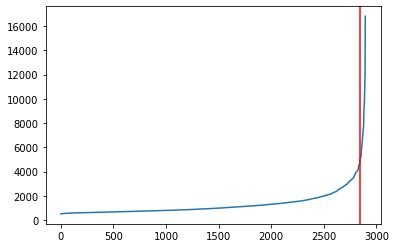

In [33]:
neighbors = NearestNeighbors(n_neighbors=75)
neighbors_fit = neighbors.fit(df2)
distances, _ = neighbors_fit.kneighbors(df2)
distances = np.sort(distances, axis=0)
distances = distances[:,74]
plt.plot(distances)
kl = KneeLocator(x=range(df2.shape[0]),y=distances,direction='increasing',curve='convex')
elbow = kl.elbow
plt.axvline(x=elbow, ymin=0, ymax = max(distances), color='red')
print('The elbow occurs at',distances[elbow])


The epsilon suggested is 5109.

In [34]:
db = DBSCAN(eps=5109, min_samples=41)

In [35]:
preds = db.fit_predict(df2)

In [36]:
sum(preds==-1)

13

According to DBSCAN there are 13 outliers

In [37]:
outliers1 = df2[preds==-1].index
outliers1

Int64Index([ 1750,  5056,  7492,  7710,  7781, 10038, 10302, 10953, 11334,
            12563, 15749, 15780, 15835],
           dtype='int64')

## Using Local Outlier Factor

In [38]:
lof = LocalOutlierFactor()

In [39]:
preds2 = lof.fit_predict(df2)
outliers2 = df2[preds2==-1].index
outliers2

Int64Index([  130,   343,   513,   965,  1267,  1433,  1750,  1931,  1939,
             2112,  2245,  2839,  2947,  2990,  3056,  3829,  4128,  4271,
             4343,  4353,  4415,  4496,  4500,  4580,  4590,  4829,  5451,
             5502,  5666,  5834,  5841,  5894,  5896,  6020,  6100,  6182,
             7318,  7710,  7967,  8073,  8370,  9366,  9513,  9959, 10069,
            10490, 10699, 10764, 11097, 11245, 11662, 12119, 12127, 12187,
            12549, 12733, 12815, 12895, 12932, 13987, 14036, 14042, 14215,
            14327, 14365, 14851, 14865, 14931, 15234, 15356, 15780, 15875],
           dtype='int64')

Local Outlier Factor predicted many more outliers

## Using 3 IQR for numeric variables to find consistent outliers.

In [40]:
outliers = {}
for column in df.columns:
    description = df[column].describe()
    q1 = description['25%']
    q3 = description['75%']
    iqr15 = 3*(q3-q1)
    indices = df[(df[column]<q1-iqr15)|(df[column]>q3+iqr15)].index
    for x in indices:
        outliers[x]=outliers.get(x,0)+1
outlier_df=pd.DataFrame({'index':outliers.keys(),'count':outliers.values()})
outliers3 = (outlier_df.sort_values(by='count',ascending=False).head(30))['index']
outliers3 = np.array(list(outliers3))
outliers3

array([15007,  1750, 10953,  7710,  9748, 15835,  4844, 11226,  8594,
       16166,  9897,   178, 14236,  8321, 14391,  3112,  4662,   475,
       14296, 14773,  5056, 10302, 12335,  7492, 14316, 10490, 12018,
       15162, 10038, 14202])

In [41]:
outliers_all3 = list(set(outliers1).intersection(set(outliers2).intersection(set(outliers3))))
outliers_all3

[1750, 7710]

2 values are found using all 3 methods, these will be dropped

In [42]:
np.intersect1d(outliers1,outliers2)

array([ 1750,  7710, 15780], dtype=int64)

3 values were found to be outliers using DBSCAN and LOF, these will be dropped.

In [43]:
df.drop(np.intersect1d(outliers1,outliers2),inplace=True)
df.drop('outlier',axis=1,inplace=True)

# EDA

## Univariate Analysis

### Dependant variable -- LBXTC

<AxesSubplot:>

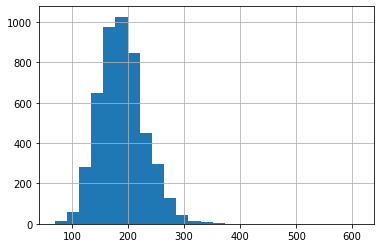

In [44]:
df.LBXTC.hist(bins=25)

The distribution is skewed.  There do appear to be outliers. As there are not many predictions above 350, it may make it hard to predict values in that range.  
I am going to log transform the variable

In [45]:
df['log_LBXTC']=np.log(df.LBXTC)
numerical_variables.append('log_LBXTC')

<AxesSubplot:>

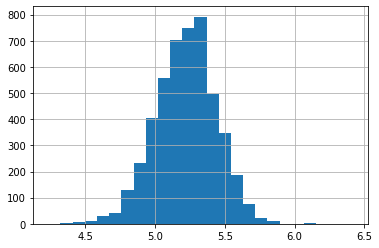

In [46]:
df.log_LBXTC.hist(bins=25)

The log of the total cholesterol is less skewed. Should this be used for modeling?

In [47]:
numerical_variables

['LBXTC',
 'RIDAGEYR',
 'BMXWT',
 'BMXHT',
 'BMXBMI',
 'BPXPLS',
 'ALQ120Q',
 'ALQ130',
 'Systolic',
 'Diastolic',
 'avg_daily_vigorous_activity',
 'avg_daily_moderate_activity',
 'DR1TKCAL_t',
 'DR1TPROT_t',
 'DR1TCARB_t',
 'DR1TSUGR_t',
 'DR1TFIBE_t',
 'DR1TTFAT_t',
 'DR1TSFAT_t',
 'DR1TMFAT_t',
 'DR1TPFAT_t',
 'DR1TCHOL_t',
 'DR1TSODI_t',
 'DR1TVD_t',
 'DR1TCALC_t',
 'DR1TIRON_t',
 'DR1TPOTA_t',
 'avgALC',
 'log_LBXTC']

### Histograms of continuous variables

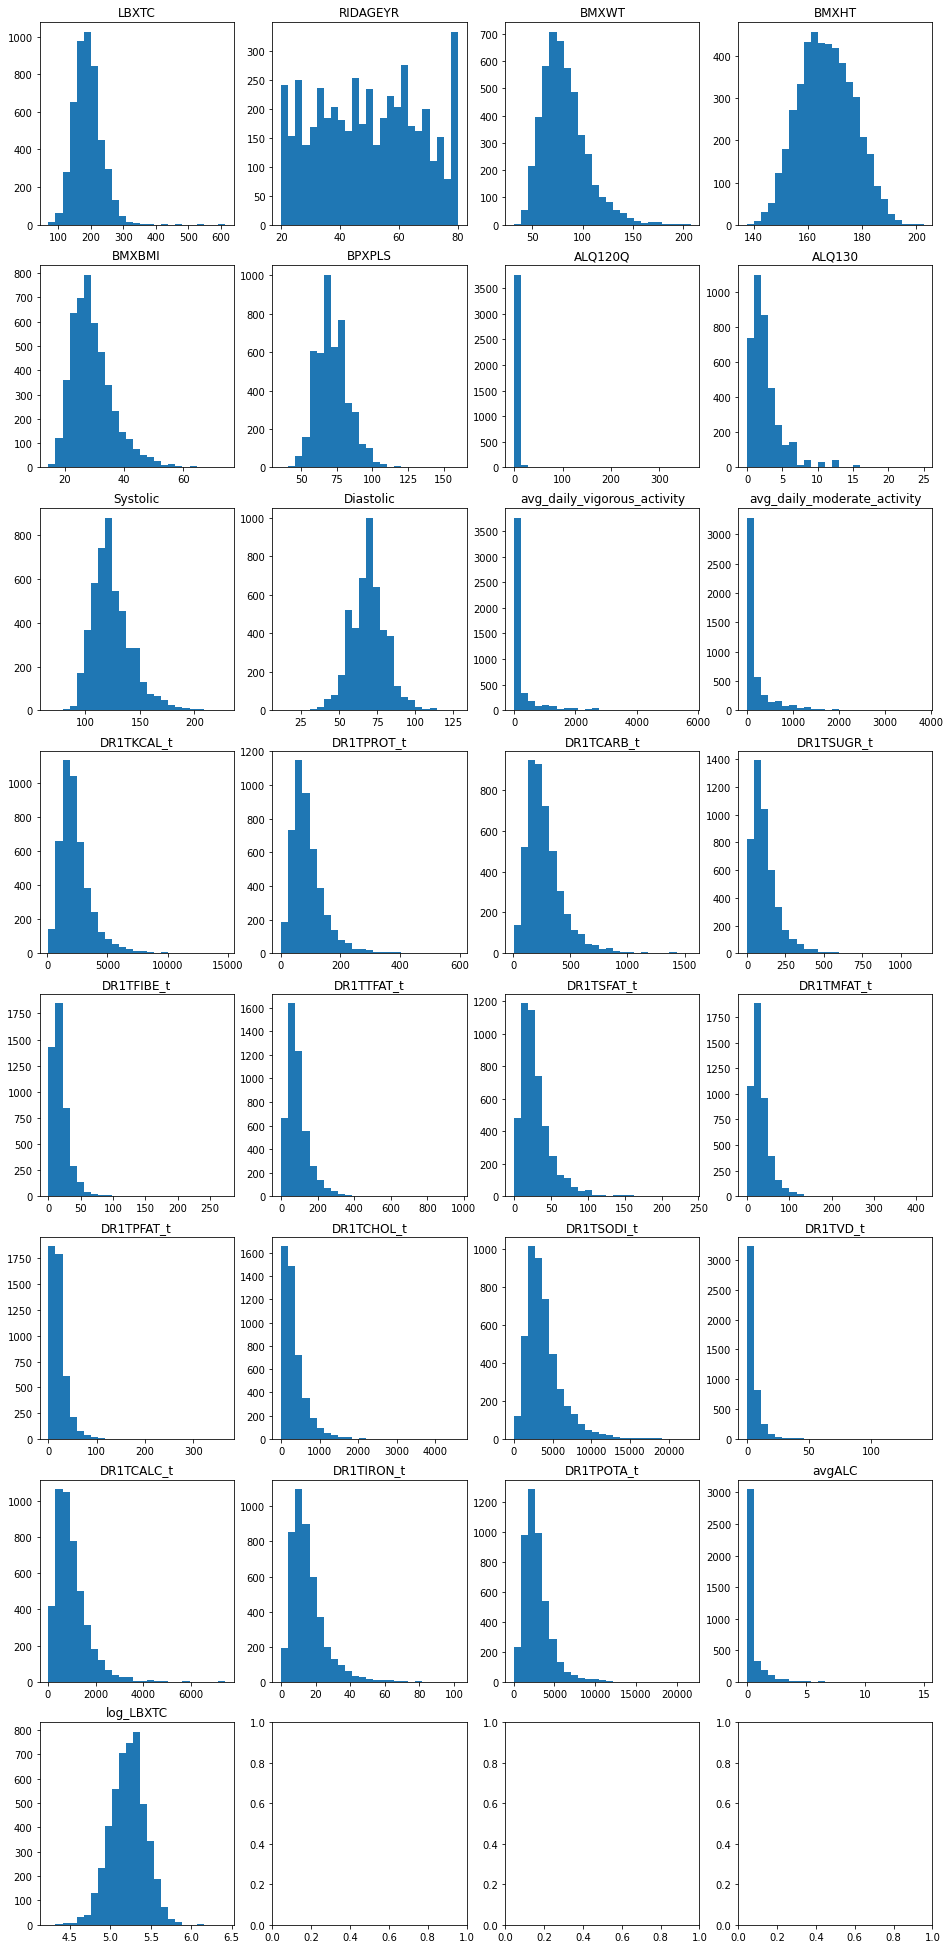

In [48]:
r,c = (0,0)
fig, axs = plt.subplots(8,4,figsize=[16,35])
for f in numerical_variables:
    axs[r,c].hist(df[f], bins=25)
    axs[r,c].set_title(f)
    c = c+1
    if c >= 4:
        r = r+1
    c = c % 4

Many distributions appear skewed.  It may help to log transform the variables.  For the same variables I am looking at boxplots.

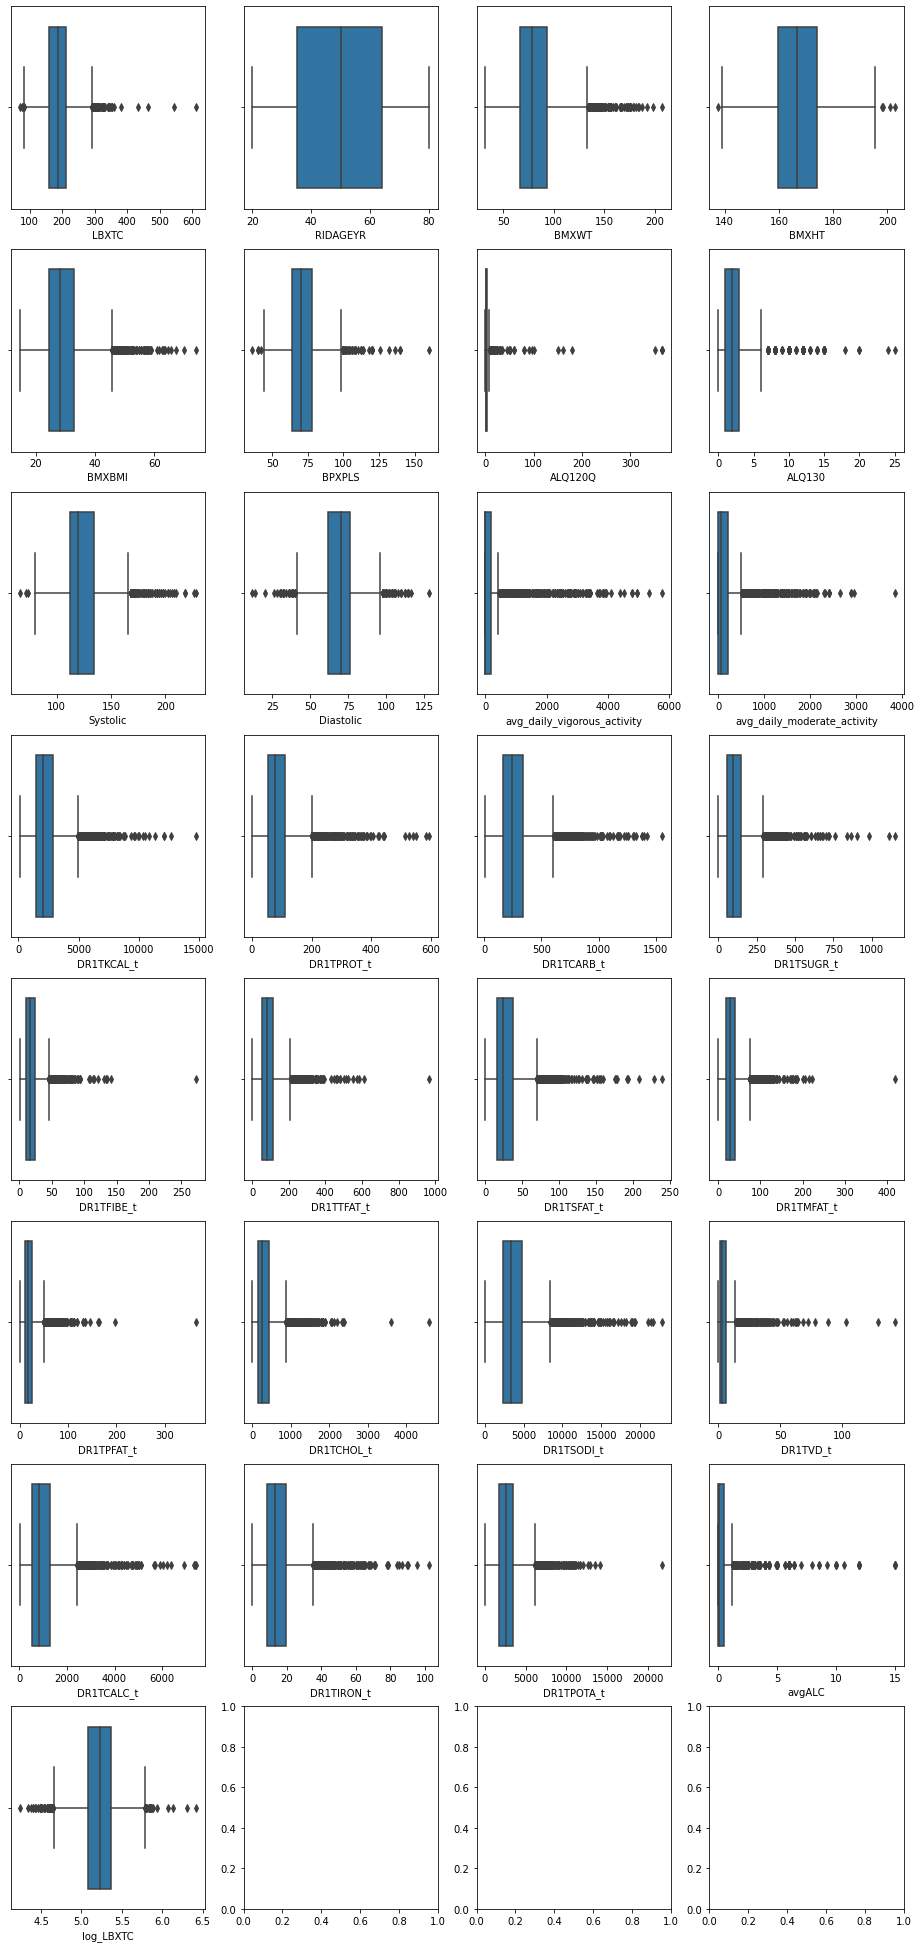

In [49]:
r,c = (0,0)
fig, axs = plt.subplots(8,4,figsize=[16,35])
for f in numerical_variables:
    sns.boxplot(x=df[f],ax=axs[r,c])
    c = c+1
    if c >= 4:
        r = r+1
        c = c % 4

As can be seen, there are many outliers.  When working with linear models, I may want to winsorize

In [50]:
df.columns

Index(['LBXTC', 'RIAGENDR', 'RIDRETH3', 'RIDAGEYR', 'BMXWT', 'BMXHT', 'BMXBMI',
       'BPXPLS', 'BPXPULS', 'ALQ120Q', 'ALQ120U', 'ALQ130', 'BPQ020',
       'BPQ050A', 'BPQ080', 'BPQ100D', 'DIQ010', 'MCQ170M', 'SMQ681',
       'Systolic', 'Diastolic', 'avg_daily_vigorous_activity',
       'avg_daily_moderate_activity', 'DR1TKCAL_t', 'DR1TPROT_t', 'DR1TCARB_t',
       'DR1TSUGR_t', 'DR1TFIBE_t', 'DR1TTFAT_t', 'DR1TSFAT_t', 'DR1TMFAT_t',
       'DR1TPFAT_t', 'DR1TCHOL_t', 'DR1TSODI_t', 'DR1TVD_t', 'DR1TCALC_t',
       'DR1TIRON_t', 'DR1TPOTA_t', 'avgALC', 'log_LBXTC'],
      dtype='object')

## Bivariate Analysis: comparison to total cholesterol

Looking at correlation between variables and LBXTC, the total cholesterol level.  Taking the absolute values so that I can look at the strength of correlation.

In [51]:
np.abs(df.corr()['LBXTC']).sort_values(ascending=False)

LBXTC                          1.000000
log_LBXTC                      0.983395
BPQ080                         0.157402
Diastolic                      0.149368
DIQ010                         0.114123
Systolic                       0.097228
BPQ100D                        0.089054
RIDAGEYR                       0.081608
BMXHT                          0.065203
RIAGENDR                       0.062918
BPXPLS                         0.050839
ALQ120U                        0.050005
BPQ050A                        0.049286
DR1TIRON_t                     0.045978
DR1TCARB_t                     0.041010
avgALC                         0.035444
MCQ170M                        0.033540
DR1TPFAT_t                     0.033120
DR1TSODI_t                     0.032707
avg_daily_moderate_activity    0.032279
DR1TSUGR_t                     0.029166
BPXPULS                        0.026972
DR1TKCAL_t                     0.026498
SMQ681                         0.024675
BPQ020                         0.024398


Blood pressure appears the most correlated however no variable is strongly correlated.  Linear models may be difficult.  The following regplots demonstrate the low correlation.

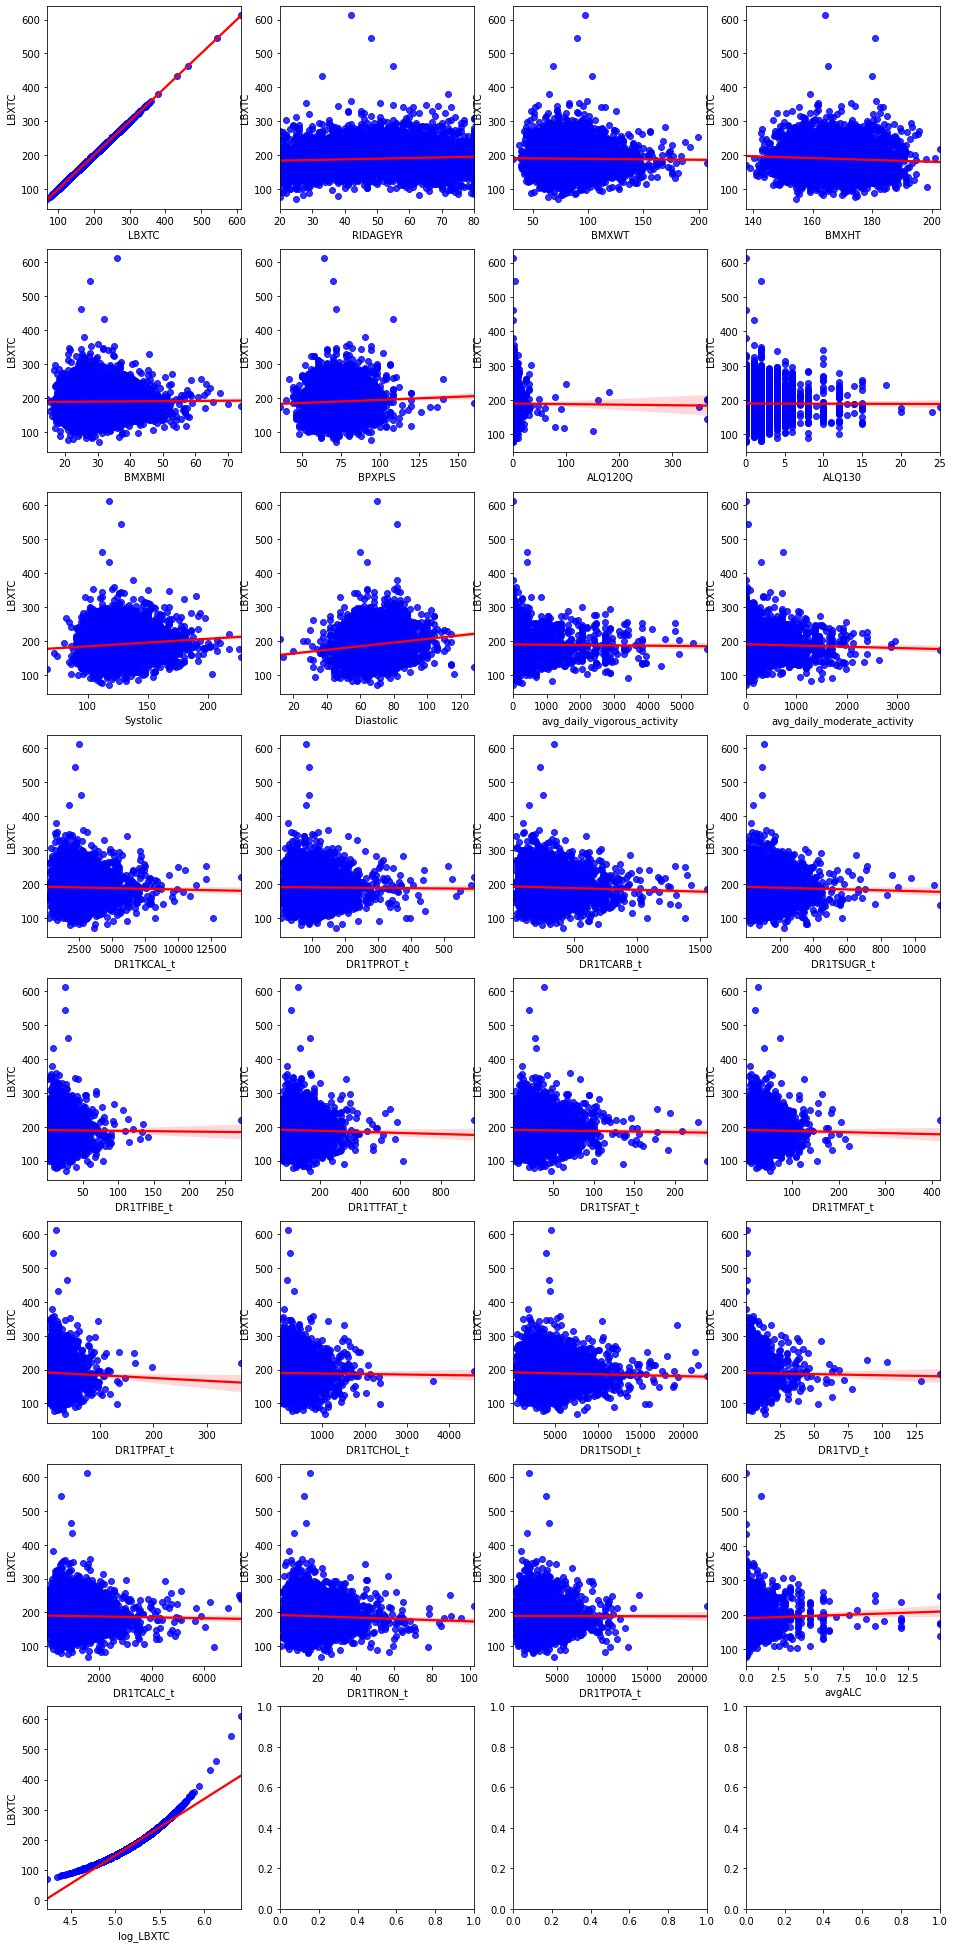

In [52]:
#sns.regplot(x='RIDAGEYR',  y='LBXTC', data=demo_merged, scatter_kws={"color": "blue"}, line_kws={"color": "red"})
r,c = (0,0)
fig, axs = plt.subplots(8,4,figsize=[16,35])
for f in numerical_variables:
    sns.regplot(x=f,y='LBXTC', data=df, ax =axs[r,c], scatter_kws={"color": "blue"}, line_kws={"color": "red"})
    c = c+1
    if c >= 4:
        r = r+1
        c = c % 4

# note to self
make more comments

### Comparing categorical variables to total cholesterol


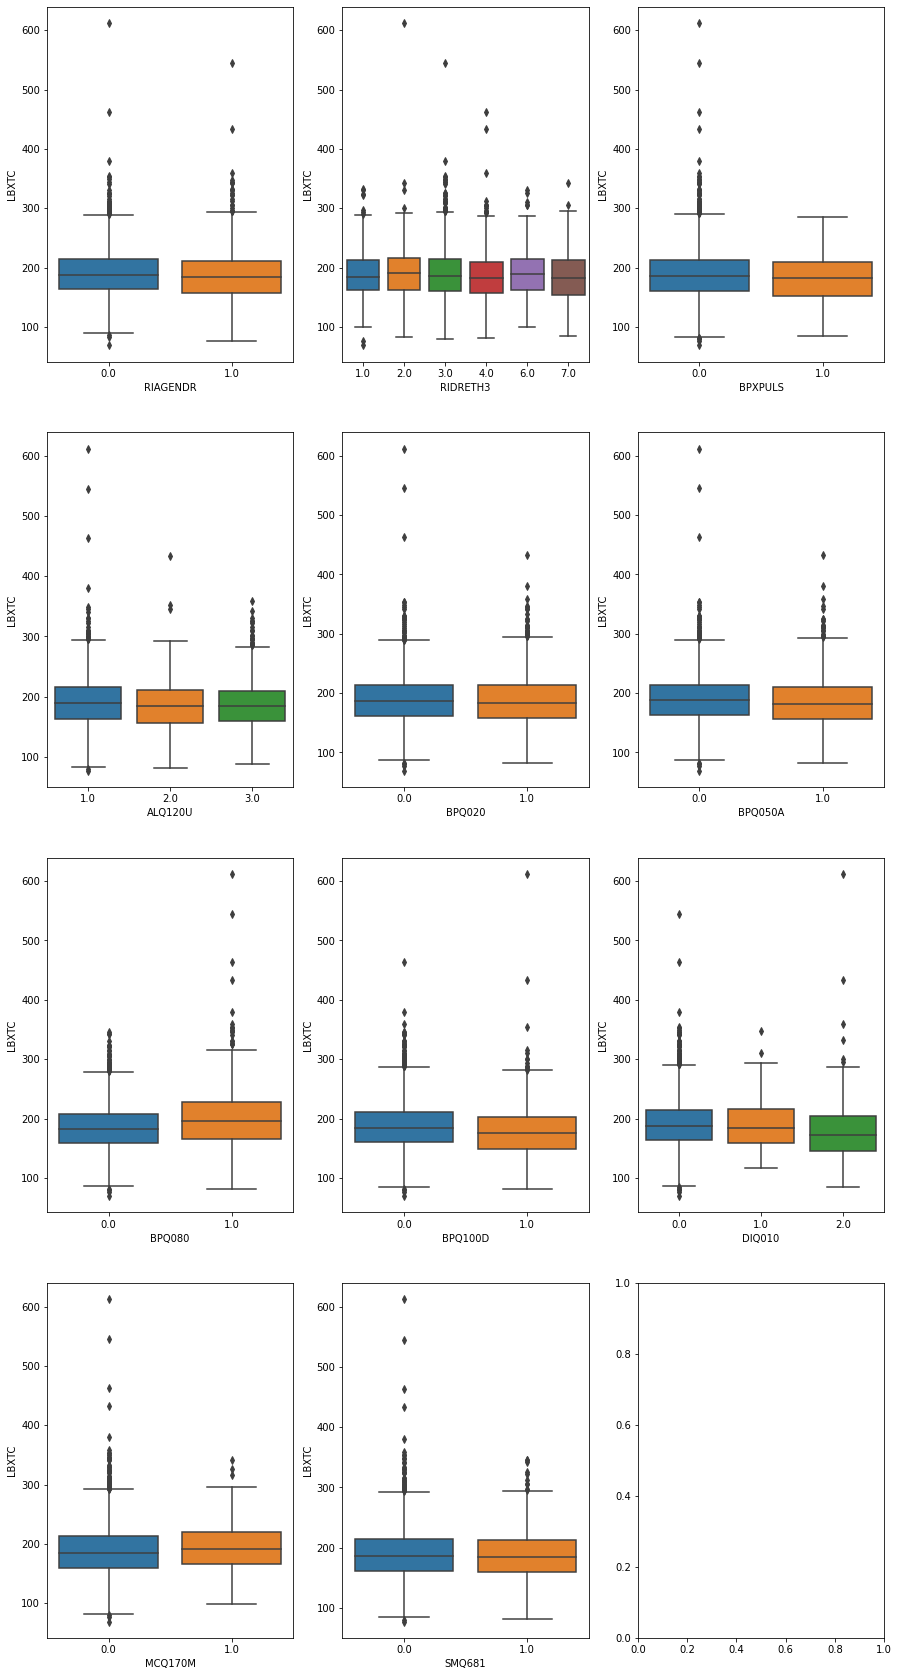

In [53]:
categorical_variables = [x for x in categorical_variables if x in df.columns]
r,c = (0,0)
fig, axs = plt.subplots(4,3,figsize=[15,30])
for f in categorical_variables:
    sns.boxplot(x=f,y='LBXTC',data=df,ax=axs[r,c])
    c = c+1
    if c >= 3:
        r = r+1
        c = c % 3

Many boxplots show the same median values with the exception of questions relating to blood pressure or diabetes.  The key differences is the number and degree of outliers one value has over another.

## Multivariate analysis

### Correlation between variables

<AxesSubplot:>

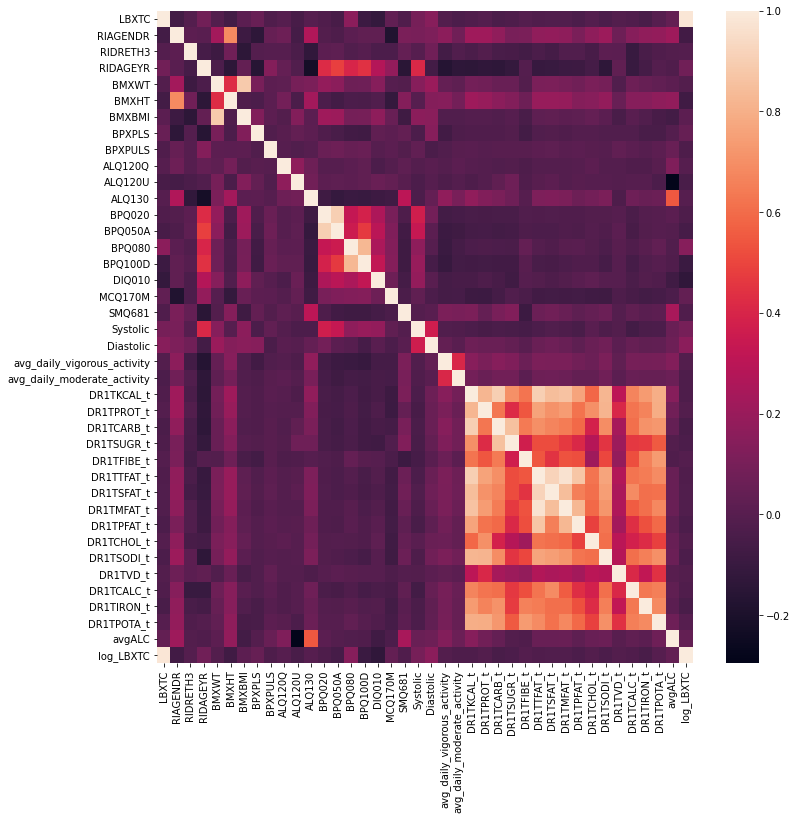

In [54]:
fig, ax = plt.subplots(figsize=(12,12))
sns.heatmap(df.corr())

There definitely appears to be correlation between nutrition variables and some physical activity variables.  I may want to use PCA at least for linear models.

Writing the dataset to a csv file before modeling

In [55]:
df.to_csv("Data/df_final.csv")

# Model creation

loading the dataset in case I am starting my notebook from here.

In [56]:
df = pd.read_csv('Data/df_final.csv')
df.drop('Unnamed: 0',axis=1,inplace=True)


In [57]:
variables = pd.read_csv('variables_final.csv')
numerical_variables = list(variables[variables.type=='numerical']['variable'])
categorical_variables = list(variables[variables.type=='categorical']['variable'])

The following model is a baseline for deep learning.  I got the idea for dropout and batch normalization from the Kaggle course: Into to Deep Learning.

In [58]:
def build_model():
    model = Sequential([
        Dense(1024, activation='relu'),
        Dropout(0.3),
        BatchNormalization(),
        Dense(1024, activation='relu'),
        Dropout(0.3),
        BatchNormalization(),
        Dense(1024, activation='relu'),
        Dropout(0.3),
        BatchNormalization(),
        Dense(1),
    ])
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

Since there is some correlation as seen by the heat map, for linear models I will need to use PCA and hence scale features.  For linear models I also need to one hot encode race, leaving one out.  For KNN I will need to use a min max scalar and also one hot encode, not leaving one out, the race variable.  For every model there needs to be imputation.  For continuous variables I will use KNN imputer and for discrete variables, I will use SimpleImputer and choose the most frequent.  Because of knn imputation, I need to scale no matter what.

OLS pipeline 
* min max scalar
* Simple imputer or KNN imputer
* One hot encode race, leaving one out
* Winsorize
* PCA 
* OLS

SVR pipeline 
* min max scalar
* Simple imputer or knn imputer
* One hot encode race, leave one out
* Winsorize
* PCA
* SVM

KNN
* min max scalar
* Simple imputer or knn imputer
* One hot encode race, leaving one out
* KNN

Decision Tree/Random forest pipeline
* min, max, scalar
* Simple imputer or knn imputer
* Decision tree or random forest

Nueral network pipeline
* min max scaler
* simple imputer or knn
* nueral network

Some questions I have

* Should I use the original variables on alcohol or my calculated average alcohol?
* Is it better to use height and weight or just BMI?
* Should I log transform skewed features?

What I plan to do to help me answer these questions is create a model for each option with everything else the same and see which performs better using OLS as a linear basis and Random forest regression as a non-linear basis.

## Answering questions

## Should I use the original variables on alcohol or my calculated average?

### OLS pipeline
#### OLS pipeline with original alcohol values

In [59]:
y = df.log_LBXTC
X1 = df.drop(['LBXTC','log_LBXTC','avgALC'],axis=1)

In [60]:
X_train, X_test, y_train, y_test = train_test_split(X1,y,test_size=0.25,random_state=625)

In [61]:
numerical_variables_a = numerical_variables.copy()

In [62]:
numerical_variables_a.remove('avgALC')

In [63]:
numeric_transformer = Pipeline(steps=[
    ('scale',MinMaxScaler()),
    ('impute',KNNImputer()),
    ('winsorizer',Winsorizer(capping_method='iqr',tail='both'))])
cat_transformer1 = Pipeline(steps=[('one_hot',OneHotEncoder(handle_unknown='error',drop='first'))])
cat_transformer2 = Pipeline(steps=[
    ('scale',MinMaxScaler()),
    ('impute',SimpleImputer(strategy='most_frequent'))
])

preprocessor = ColumnTransformer(transformers=[
    ('num',numeric_transformer,numerical_variables_a),
    ('encode',cat_transformer1,['RIDRETH3']),
    ('impute_cat',cat_transformer2,categorical_variables)])

lr1 = Pipeline(steps =[
    ('preprocessor',preprocessor),
    ('PCA',PCA(0.95)),
    ('ols', LinearRegression())])

In [64]:
lr1.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scale',
                                                                   MinMaxScaler()),
                                                                  ('impute',
                                                                   KNNImputer()),
                                                                  ('winsorizer',
                                                                   Winsorizer(capping_method='iqr',
                                                                              tail='both'))]),
                                                  ['RIDAGEYR', 'BMXWT', 'BMXHT',
                                                   'BMXBMI', 'BPXPLS',
                                                   'ALQ120Q', 'ALQ130',
                                                   'Systolic', 'Diastolic',
               

In [65]:
lr1.score(X_train,y_train)

0.151635943912363

### OLS with transformed alcohol variable  

In [66]:
numerical_variables_b = numerical_variables.copy()
numerical_variables_b.remove('ALQ120Q')
numerical_variables_b.remove('ALQ130')

In [67]:
categorical_variables_b = categorical_variables.copy()
categorical_variables_b.remove('ALQ120U')

In [68]:
y = df.log_LBXTC
X2 = df.drop(['LBXTC','log_LBXTC'],axis=1)

In [69]:
X_train, X_test, y_train, y_test = train_test_split(X2,y,test_size=0.25,random_state=625)

In [70]:
numeric_transformer = Pipeline(steps=[
    ('scale',MinMaxScaler()),
    ('impute',KNNImputer()),
    ('winsorizer',Winsorizer(capping_method='iqr',tail='both'))])
cat_transformer1 = Pipeline(steps=[('one_hot',OneHotEncoder(handle_unknown='error',drop='first'))])
cat_transformer2 = Pipeline(steps=[
    ('scale',MinMaxScaler()),
    ('impute',SimpleImputer(strategy='most_frequent'))
])

preprocessor = ColumnTransformer(transformers=[
    ('num',numeric_transformer,numerical_variables_b),
    ('encode',cat_transformer1,['RIDRETH3']),
    ('impute_cat',cat_transformer2,categorical_variables_b)])

lr1 = Pipeline(steps =[
    ('preprocessor',preprocessor),
    ('PCA',PCA(0.95)),
    ('ols', LinearRegression())])

In [71]:
lr1.fit(X_train,y_train)
lr1.score(X_train,y_train)

0.15552272472396234

The results are slightly better with the transformed alcohol for OLS

### Decision Tree Regression pipeline
#### Decision Tree with original alcohol values

In [72]:
y = df.log_LBXTC
X1 = df.drop(['LBXTC','log_LBXTC','avgALC'],axis=1)

In [73]:
X_train, X_test, y_train, y_test = train_test_split(X1,y,test_size=0.25,random_state=625)

In [74]:
numerical_variables_a = numerical_variables.copy()
numerical_variables_a.remove('avgALC')

In [75]:
categorical_variables_a = categorical_variables.copy()

In [76]:
numeric_transformer = Pipeline(steps=[
    ('scale',MinMaxScaler()),
    ('impute',KNNImputer())])
cat_transformer2 = Pipeline(steps=[
    ('scale',MinMaxScaler()),
    ('impute',SimpleImputer(strategy='most_frequent'))
])

preprocessor = ColumnTransformer(transformers=[
    ('num',numeric_transformer,numerical_variables_a),
    ('impute_cat',cat_transformer2,categorical_variables_a+['RIDRETH3'])])

dt1 = Pipeline(steps =[
    ('preprocessor',preprocessor),
    ('decision_tree',DecisionTreeRegressor(random_state=75,max_depth=7))])


In [77]:
dt1.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scale',
                                                                   MinMaxScaler()),
                                                                  ('impute',
                                                                   KNNImputer())]),
                                                  ['RIDAGEYR', 'BMXWT', 'BMXHT',
                                                   'BMXBMI', 'BPXPLS',
                                                   'ALQ120Q', 'ALQ130',
                                                   'Systolic', 'Diastolic',
                                                   'avg_daily_vigorous_activity',
                                                   'avg_daily_moderate_activity',
                                                   'DR1TKCAL_t', 'DR1TPROT_t',
                                              

In [78]:
dt1.score(X_train,y_train)

0.3251226702384542

#### Decision Tree Regressor with transformed alcohol

In [79]:
X2 = df.drop(['LBXTC','log_LBXTC'],axis=1)

In [80]:
X_train, X_test, y_train, y_test = train_test_split(X2,y,test_size=0.25,random_state=625)

In [81]:
numerical_variables_b = numerical_variables.copy()
numerical_variables_b.remove('ALQ120Q')
numerical_variables_b.remove('ALQ130')

In [82]:
categorical_variables_b = categorical_variables.copy()
categorical_variables_b.remove('ALQ120U')

In [83]:
numeric_transformer = Pipeline(steps=[
    ('scale',MinMaxScaler()),
    ('impute',KNNImputer())])
cat_transformer2 = Pipeline(steps=[
    ('scale',MinMaxScaler()),
    ('impute',SimpleImputer(strategy='most_frequent'))
])

preprocessor = ColumnTransformer(transformers=[
    ('num',numeric_transformer,numerical_variables_b),
    ('impute_cat',cat_transformer2,categorical_variables_b+['RIDRETH3'])])

dt1 = Pipeline(steps =[
    ('preprocessor',preprocessor),
    ('decision_tree',DecisionTreeRegressor(random_state=75,max_depth=7))])


In [84]:
dt1.fit(X_train,y_train)
dt1.score(X_train,y_train)

0.32672251932833374

With both, the models performed better with transformed alcohol.  For this reason the variables will be dropped from variables.

## Is it better to use height and weight or just BMI?
### OLS pipeline
#### OLS pipeline with height and weight

In [85]:
X1 = df.drop(['LBXTC','log_LBXTC'],axis=1)
y = df.log_LBXTC

In [86]:
numerical_variables_a = numerical_variables.copy()
numerical_variables_a.remove('BMXBMI')

In [87]:
numeric_transformer = Pipeline(steps=[
    ('scale',MinMaxScaler()),
    ('impute',KNNImputer()),
    ('winsorizer',Winsorizer(capping_method='iqr',tail='both'))])
cat_transformer1 = Pipeline(steps=[('one_hot',OneHotEncoder(handle_unknown='error',drop='first'))])
cat_transformer2 = Pipeline(steps=[
    ('scale',MinMaxScaler()),
    ('impute',SimpleImputer(strategy='most_frequent'))
])

preprocessor = ColumnTransformer(transformers=[
    ('num',numeric_transformer,numerical_variables_a),
    ('encode',cat_transformer1,['RIDRETH3']),
    ('impute_cat',cat_transformer2,categorical_variables)])

lr1 = Pipeline(steps =[
    ('preprocessor',preprocessor),
    ('PCA',PCA(0.95)),
    ('ols', LinearRegression())])

In [88]:
X_train, X_test, y_train, y_test = train_test_split(X1,y,test_size=0.25,random_state=625)

In [89]:
lr1.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scale',
                                                                   MinMaxScaler()),
                                                                  ('impute',
                                                                   KNNImputer()),
                                                                  ('winsorizer',
                                                                   Winsorizer(capping_method='iqr',
                                                                              tail='both'))]),
                                                  ['RIDAGEYR', 'BMXWT', 'BMXHT',
                                                   'BPXPLS', 'ALQ120Q',
                                                   'ALQ130', 'Systolic',
                                                   'Diastolic',
                         

In [90]:
lr1.score(X_train,y_train)

0.14771349223757668

#### OLS using just BMI

In [91]:
X2 = df.drop(['LBXTC','log_LBXTC'],axis=1)
y = df.log_LBXTC

In [92]:
numerical_variables_b = numerical_variables.copy()
numerical_variables_b.remove('BMXWT')
numerical_variables_b.remove('BMXHT')

In [93]:
numeric_transformer = Pipeline(steps=[
    ('scale',MinMaxScaler()),
    ('impute',KNNImputer()),
    ('winsorizer',Winsorizer(capping_method='iqr',tail='both'))])
cat_transformer1 = Pipeline(steps=[('one_hot',OneHotEncoder(handle_unknown='error',drop='first'))])
cat_transformer2 = Pipeline(steps=[
    ('scale',MinMaxScaler()),
    ('impute',SimpleImputer(strategy='most_frequent'))
])

preprocessor = ColumnTransformer(transformers=[
    ('num',numeric_transformer,numerical_variables_b),
    ('encode',cat_transformer1,['RIDRETH3']),
    ('impute_cat',cat_transformer2,categorical_variables)])

lr1 = Pipeline(steps =[
    ('preprocessor',preprocessor),
    ('PCA',PCA(0.95)),
    ('ols', LinearRegression())])

In [94]:
X_train, X_test, y_train, y_test = train_test_split(X2,y,test_size=0.25,random_state=625)

In [95]:
lr1.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scale',
                                                                   MinMaxScaler()),
                                                                  ('impute',
                                                                   KNNImputer()),
                                                                  ('winsorizer',
                                                                   Winsorizer(capping_method='iqr',
                                                                              tail='both'))]),
                                                  ['RIDAGEYR', 'BMXBMI',
                                                   'BPXPLS', 'ALQ120Q',
                                                   'ALQ130', 'Systolic',
                                                   'Diastolic',
                                 

In [96]:
lr1.score(X_train,y_train)

0.14802933623716152

OLS performs better using just BMI

### Decision Tree pipeline
#### Decision Tree pipeline with height and weight

In [97]:
y = df.log_LBXTC
X1 = df.drop(['LBXTC','log_LBXTC'],axis=1)

In [98]:
numerical_variables_a = numerical_variables.copy()
numerical_variables_a.remove('BMXBMI')

In [99]:
numeric_transformer = Pipeline(steps=[
    ('scale',MinMaxScaler()),
    ('impute',KNNImputer())])
cat_transformer2 = Pipeline(steps=[
    ('scale',MinMaxScaler()),
    ('impute',SimpleImputer(strategy='most_frequent'))
])

preprocessor = ColumnTransformer(transformers=[
    ('num',numeric_transformer,numerical_variables_a),
    ('impute_cat',cat_transformer2,categorical_variables+['RIDRETH3'])])

dt1 = Pipeline(steps =[
    ('preprocessor',preprocessor),
    ('decision_tree',DecisionTreeRegressor(random_state=75,max_depth=7))])


In [100]:
X_train, X_test, y_train, y_test = train_test_split(X1,y,test_size=0.25,random_state=625)

In [101]:
dt1.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scale',
                                                                   MinMaxScaler()),
                                                                  ('impute',
                                                                   KNNImputer())]),
                                                  ['RIDAGEYR', 'BMXWT', 'BMXHT',
                                                   'BPXPLS', 'ALQ120Q',
                                                   'ALQ130', 'Systolic',
                                                   'Diastolic',
                                                   'avg_daily_vigorous_activity',
                                                   'avg_daily_moderate_activity',
                                                   'DR1TKCAL_t', 'DR1TPROT_t',
                                                   'DR1T

In [102]:
dt1.score(X_train,y_train)

0.32297738774098494

#### Decision tree using BMI

In [103]:
y = df.log_LBXTC
X2 = df.drop(['LBXTC','log_LBXTC'],axis=1)

In [104]:
numerical_variables_b = numerical_variables.copy()
numerical_variables_b.remove('BMXWT')
numerical_variables_b.remove('BMXHT')

In [105]:
numeric_transformer = Pipeline(steps=[
    ('scale',MinMaxScaler()),
    ('impute',KNNImputer())])
cat_transformer2 = Pipeline(steps=[
    ('scale',MinMaxScaler()),
    ('impute',SimpleImputer(strategy='most_frequent'))
])

preprocessor = ColumnTransformer(transformers=[
    ('num',numeric_transformer,numerical_variables_b),
    ('impute_cat',cat_transformer2,categorical_variables+['RIDRETH3'])])

dt1 = Pipeline(steps =[
    ('preprocessor',preprocessor),
    ('decision_tree',DecisionTreeRegressor(random_state=75,max_depth=7))])


In [106]:
X_train, X_test, y_train, y_test = train_test_split(X2,y,test_size=0.25,random_state=625)

In [107]:
dt1.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scale',
                                                                   MinMaxScaler()),
                                                                  ('impute',
                                                                   KNNImputer())]),
                                                  ['RIDAGEYR', 'BMXBMI',
                                                   'BPXPLS', 'ALQ120Q',
                                                   'ALQ130', 'Systolic',
                                                   'Diastolic',
                                                   'avg_daily_vigorous_activity',
                                                   'avg_daily_moderate_activity',
                                                   'DR1TKCAL_t', 'DR1TPROT_t',
                                                   'DR1TCARB_t',

In [108]:
dt1.score(X_train,y_train)

0.32686095840113716

Both perform better with BMI only.  Therefore height and weight will be dropped.

### Should I log transform skewed variables?

### OLS pipeline without log transformed variables

In [109]:
y = df.log_LBXTC
X = df.drop(['LBXTC','log_LBXTC'],axis=1)

In [110]:
numerical_variables = list(variables[variables.type=='numerical']['variable'])
categorical_variables = list(variables[variables.type=='categorical']['variable'])

In [111]:
numeric_transformer = Pipeline(steps=[
    ('scale',MinMaxScaler()),
    ('impute',KNNImputer()),
    ('winsorizer',Winsorizer(capping_method='iqr',tail='both'))])
cat_transformer1 = Pipeline(steps=[('one_hot',OneHotEncoder(handle_unknown='error',drop='first'))])
cat_transformer2 = Pipeline(steps=[
    ('scale',MinMaxScaler()),
    ('impute',SimpleImputer(strategy='most_frequent'))
])

preprocessor = ColumnTransformer(transformers=[
    ('num',numeric_transformer,numerical_variables),
    ('encode',cat_transformer1,['RIDRETH3']),
    ('impute_cat',cat_transformer2,categorical_variables)])

lr1 = Pipeline(steps =[
    ('preprocessor',preprocessor),
    ('PCA',PCA(0.95)),
    ('ols', LinearRegression())])

In [112]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25,random_state=625)

In [113]:
lr1.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scale',
                                                                   MinMaxScaler()),
                                                                  ('impute',
                                                                   KNNImputer()),
                                                                  ('winsorizer',
                                                                   Winsorizer(capping_method='iqr',
                                                                              tail='both'))]),
                                                  ['RIDAGEYR', 'BMXWT', 'BMXHT',
                                                   'BMXBMI', 'BPXPLS',
                                                   'ALQ120Q', 'ALQ130',
                                                   'Systolic', 'Diastolic',
               

In [114]:
lr1.score(X_train,y_train)

0.15160144587979996

#### OLS log transforming skewed variables

In [115]:
numerical_not_skewed = list(variables[variables.skewed=='no']['variable'])
numerical_variables_skewed = list(variables[variables.skewed=='yes']['variable'])

In [116]:
numeric_transformer1 = Pipeline(steps=[
    ('scale',MinMaxScaler()),
    ('impute',KNNImputer()),
    ('winsorizer',Winsorizer(capping_method='iqr',tail='both'))])
numeric_transformer2 = Pipeline(steps=[
    ('log_transform',FunctionTransformer(np.log1p)),
    ('scale',MinMaxScaler()),
    ('impute',KNNImputer()),
    ('winsorizer',Winsorizer(capping_method='iqr',tail='both'))])
cat_transformer1 = Pipeline(steps=[('one_hot',OneHotEncoder(handle_unknown='error',drop='first'))])
cat_transformer2 = Pipeline(steps=[
    ('scale',MinMaxScaler()),
    ('impute',SimpleImputer(strategy='most_frequent'))
])

preprocessor = ColumnTransformer(transformers=[
    ('num1',numeric_transformer1,numerical_not_skewed),
    ('num2',numeric_transformer2,numerical_variables_skewed),
    ('encode',cat_transformer1,['RIDRETH3']),
    ('impute_cat',cat_transformer2,categorical_variables)])

lr1 = Pipeline(steps =[
    ('preprocessor',preprocessor),
    ('PCA',PCA(0.95)),
    ('ols', LinearRegression())])

In [117]:
lr1.fit(X_train,y_train)
lr1.score(X_train,y_train)

0.15948263008555763

For OLS the model performs better when the skewed variables are log transformed.

#### Decision tree regressor without log transforming variables

In [118]:
y = df.log_LBXTC
X = df.drop(['LBXTC','log_LBXTC'],axis=1)

In [119]:
numerical_variables = list(variables[variables.type=='numerical']['variable'])

In [120]:
numeric_transformer = Pipeline(steps=[
    ('scale',MinMaxScaler()),
    ('impute',KNNImputer())])
cat_transformer2 = Pipeline(steps=[
    ('scale',MinMaxScaler()),
    ('impute',SimpleImputer(strategy='most_frequent'))
])

preprocessor = ColumnTransformer(transformers=[
    ('num',numeric_transformer,numerical_variables),
    ('impute_cat',cat_transformer2,categorical_variables+['RIDRETH3'])])

dt1 = Pipeline(steps =[
    ('preprocessor',preprocessor),
    ('decision_tree',DecisionTreeRegressor(random_state=75,max_depth=7))])


In [121]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25,random_state=625)

In [122]:
dt1.fit(X_train,y_train)
dt1.score(X_train,y_train)

0.32597048585759747

#### Decision tree regression with log transformed variables

In [123]:
numerical_not_skewed = list(variables[variables.skewed=='no']['variable'])
numerical_variables_skewed = list(variables[variables.skewed=='yes']['variable'])

In [124]:
numeric_transformer1 = Pipeline(steps=[
    ('scale',MinMaxScaler()),
    ('impute',KNNImputer())])
cat_transformer2 = Pipeline(steps=[
    ('scale',MinMaxScaler()),
    ('impute',SimpleImputer(strategy='most_frequent'))
])
numeric_transformer2 = Pipeline(steps=[
    ('log_transform',FunctionTransformer(np.log1p)),
    ('scale',MinMaxScaler()),
    ('impute',KNNImputer())])

preprocessor = ColumnTransformer(transformers=[
    ('num1',numeric_transformer1,numerical_not_skewed),
    ('num2',numeric_transformer2,numerical_variables_skewed),
    ('impute_cat',cat_transformer2,categorical_variables+['RIDRETH3'])])

dt1 = Pipeline(steps =[
    ('preprocessor',preprocessor),
    ('decision_tree',DecisionTreeRegressor(random_state=75,max_depth=7))])

In [125]:
dt1.fit(X_train,y_train)
dt1.score(X_train,y_train)

0.33477792379410154

For both, it works better for log transforming variables.

### Results

* Use calculated average alcohol intake
* Use BMI
* log transform skewed variables



In [126]:
metrics = {'model':[],'r2':[],'adjusted_r2':[],'train_MAE':[],'train_RMSE':[],'test_MAE':[],'test_RMSE':[]}

Dropping height, weight and alcohol survey variables

In [127]:
variables.drop([3,4,8,9,10],inplace=True)

## Creating Models
My plan is to use OLS, KNN, SVR, Random Forests, and Nueral networks to create a base model and compare their metrics.  Then I will choose the top performing model and do hyperparameter tuning.


### OLS

In [128]:
y = df.log_LBXTC
X = df.drop(['LBXTC','log_LBXTC'],axis=1)

In [129]:
variables_ols = variables.copy()


In [130]:
numerical_not_skewed = list(variables_ols[variables_ols.skewed=='no']['variable'])
numerical_variables_skewed = list(variables_ols[variables_ols.skewed=='yes']['variable'])

In [131]:
categorical_variables = list(variables[variables.type=='categorical']['variable'])

In [132]:
numeric_transformer1 = Pipeline(steps=[
    ('scale',MinMaxScaler()),
    ('impute',KNNImputer()),
    ('winsorizer',Winsorizer(capping_method='iqr',tail='both'))])
numeric_transformer2 = Pipeline(steps=[
    ('log_transform',FunctionTransformer(np.log1p)),
    ('scale',MinMaxScaler()),
    ('impute',KNNImputer()),
    ('winsorizer',Winsorizer(capping_method='iqr',tail='both'))])
cat_transformer1 = Pipeline(steps=[('one_hot',OneHotEncoder(handle_unknown='error',drop='first'))])
cat_transformer2 = Pipeline(steps=[
    ('scale',MinMaxScaler()),
    ('impute',SimpleImputer(strategy='most_frequent'))
])

preprocessor = ColumnTransformer(transformers=[
    ('num1',numeric_transformer1,numerical_not_skewed),
    ('num2',numeric_transformer2,numerical_variables_skewed),
    ('encode',cat_transformer1,['RIDRETH3']),
    ('impute_cat',cat_transformer2,categorical_variables)])

lr1 = Pipeline(steps =[
    ('preprocessor',preprocessor),
    ('PCA',PCA(0.95)),
    ('ols', LinearRegression())])

In [133]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25,random_state=625)

In [134]:
lr1.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num1',
                                                  Pipeline(steps=[('scale',
                                                                   MinMaxScaler()),
                                                                  ('impute',
                                                                   KNNImputer()),
                                                                  ('winsorizer',
                                                                   Winsorizer(capping_method='iqr',
                                                                              tail='both'))]),
                                                  ['RIDAGEYR', 'Diastolic']),
                                                 ('num2',
                                                  Pipeline(steps=[('log_transform',
                                                                   FunctionTransformer(func=<u

In [135]:
r2 = lr1.score(X_train,y_train)
r2

0.15621423350535513

The r2 value for this model is 0.1375 meaning only about 14 percent of the variance can be explained by this model.  This model doesn't perform well.

In [136]:
y_preds = lr1.predict(X_train)

In [137]:
k = lr1.named_steps['ols'].n_features_in_
n = X_train.shape[0]
ar2 = 1-(1-r2)*(n-1)/(n-k-1)
ar2

0.1517385412766007

The adjusted r2 value, which will be used to help compare models as different models will use different features, is 0.133

In [138]:
training_mae = mean_absolute_error(y_train,y_preds)
training_mae

0.1561979167137544

The mean absolute error for the training set is 0.16 meaning, on average the predicted value differs from the true value by 0.15.  Since we took the log of the y values, this is hard to interpret in terms of total cholesterol.

In [139]:
training_rmse = mean_squared_error(y_train,y_preds,squared=False)
training_rmse

0.20083098896105073

The training root mean square error is 0.2.  To find the test MAE and RMSE I am going to use cross validation score

In [140]:
test_mae = np.abs(cross_val_score(estimator=lr1,X=X_train,y=y_train,scoring='neg_mean_absolute_error')).mean()
test_mae

0.15693984066789227

In [141]:
test_rmse = np.sqrt(np.abs(cross_val_score(estimator=lr1,X=X_train,y=y_train,scoring='neg_mean_squared_error')).mean())
test_rmse

0.201792571636449

Appending these to the metrics variable...

In [142]:
metrics['model'].append('ols')
metrics['r2'].append(r2)
metrics['adjusted_r2'].append(ar2)
metrics['train_MAE'].append(training_mae)
metrics['train_RMSE'].append(training_rmse)
metrics['test_MAE'].append(test_mae)
metrics['test_RMSE'].append(test_rmse)

Now, looking at how predicted values compare to true values...

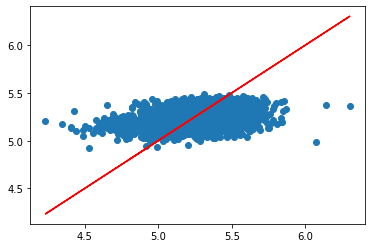

In [143]:
plt.scatter(y_train, y_preds)
plt.plot(y_train, y_train, color="red")

As you can see the model performs poorly.  Lower values and higher values will not be predicted.


# SVR regression

In [144]:
y = df.log_LBXTC
X = df.drop(['LBXTC','log_LBXTC'],axis=1)

In [145]:
variables

,variable,type,skewed
0,RIAGENDR,categorical,NaN
1,RIDRETH3,categorical__to_encode,NaN
2,RIDAGEYR,numerical,no
5,BMXBMI,numerical,yes
6,BPXPLS,numerical,yes
7,BPXPULS,categorical,NaN
11,BPQ020,categorical,NaN
12,BPQ050A,categorical,NaN
13,BPQ080,categorical,NaN
14,BPQ100D,categorical,NaN


In [146]:
numerical_not_skewed = list(variables[variables.skewed=='no']['variable'])
numerical_variables_skewed = list(variables[variables.skewed=='yes']['variable'])

In [147]:
numerical_variables_skewed

['BMXBMI',
 'BPXPLS',
 'Systolic',
 'avg_daily_vigorous_activity',
 'avg_daily_moderate_activity',
 'DR1TKCAL_t',
 'DR1TPROT_t',
 'DR1TCARB_t',
 'DR1TSUGR_t',
 'DR1TFIBE_t',
 'DR1TTFAT_t',
 'DR1TSFAT_t',
 'DR1TMFAT_t',
 'DR1TPFAT_t',
 'DR1TCHOL_t',
 'DR1TSODI_t',
 'DR1TVD_t',
 'DR1TCALC_t',
 'DR1TIRON_t',
 'DR1TPOTA_t',
 'avgALC']

In [148]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25,random_state=625)

In [149]:
numeric_transformer1 = Pipeline(steps=[
    ('scale',MinMaxScaler()),
    ('impute',KNNImputer()),
    ('winsorizer',Winsorizer(capping_method='iqr',tail='both'))])
numeric_transformer2 = Pipeline(steps=[
    ('log_transform',FunctionTransformer(np.log1p)),
    ('scale',MinMaxScaler()),
    ('impute',KNNImputer()),
    ('winsorizer',Winsorizer(capping_method='iqr',tail='both'))])
cat_transformer1 = Pipeline(steps=[('one_hot',OneHotEncoder(handle_unknown='error',drop='first'))])
cat_transformer2 = Pipeline(steps=[
    ('scale',MinMaxScaler()),
    ('impute',SimpleImputer(strategy='most_frequent'))
])

preprocessor = ColumnTransformer(transformers=[
    ('num1',numeric_transformer1,numerical_not_skewed),
    ('num2',numeric_transformer2,numerical_variables_skewed),
    ('encode',cat_transformer1,['RIDRETH3']),
    ('impute_cat',cat_transformer2,categorical_variables)])

svr1 = Pipeline(steps =[
    ('preprocessor',preprocessor),
    ('PCA',PCA(0.95)),
    ('svr', SVR())])

In [150]:
svr1.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num1',
                                                  Pipeline(steps=[('scale',
                                                                   MinMaxScaler()),
                                                                  ('impute',
                                                                   KNNImputer()),
                                                                  ('winsorizer',
                                                                   Winsorizer(capping_method='iqr',
                                                                              tail='both'))]),
                                                  ['RIDAGEYR', 'Diastolic']),
                                                 ('num2',
                                                  Pipeline(steps=[('log_transform',
                                                                   FunctionTransformer(func=<u

In [151]:
r2 = svr1.score(X_train,y_train)
r2

0.42657998981763634

The r2 score is better for support vector regression.  

In [152]:
y_preds = svr1.predict(X_train)


In [153]:
k = svr1.named_steps['svr'].n_features_in_
n = X_train.shape[0]
ar2 = 1-(1-r2)*(n-1)/(n-k-1)
ar2

0.4235383984738438

In [154]:
training_mae = mean_absolute_error(y_train,y_preds)
training_mae

0.12823148073761775

In [155]:
training_rmse = mean_squared_error(y_train,y_preds,squared=False)
training_rmse

0.1655583354768698

In [156]:
test_mae = np.abs(cross_val_score(estimator=svr1,X=X_train,y=y_train,scoring='neg_mean_absolute_error')).mean()
test_mae

0.16315993634017306

In [157]:
test_rmse = np.sqrt(np.abs(cross_val_score(estimator=svr1,X=X_train,y=y_train,scoring='neg_mean_squared_error')).mean())
test_rmse

0.20880119788644255

In [158]:
metrics['model'].append('svr')
metrics['r2'].append(r2)
metrics['adjusted_r2'].append(ar2)
metrics['train_MAE'].append(training_mae)
metrics['train_RMSE'].append(training_rmse)
metrics['test_MAE'].append(test_mae)
metrics['test_RMSE'].append(test_rmse)

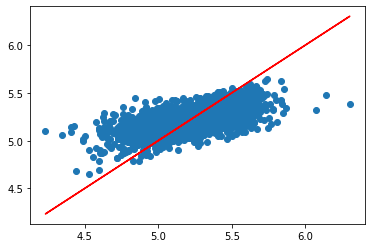

In [159]:
plt.scatter(y_train, y_preds)
plt.plot(y_train, y_train, color="red")

As you can see, the model still struggles to predict extreme values but is better than OLS

## KNN Regression

In [160]:
numeric_transformer1 = Pipeline(steps=[
    ('scale',MinMaxScaler()),
    ('impute',KNNImputer())])
numeric_transformer2 = Pipeline(steps=[
    ('log_transform',FunctionTransformer(np.log1p)),
    ('scale',MinMaxScaler()),
    ('impute',KNNImputer())])
cat_transformer1 = Pipeline(steps=[('one_hot',OneHotEncoder(handle_unknown='error'))])
cat_transformer2 = Pipeline(steps=[
    ('scale',MinMaxScaler()),
    ('impute',SimpleImputer(strategy='most_frequent'))
])

preprocessor = ColumnTransformer(transformers=[
    ('num1',numeric_transformer1,numerical_not_skewed),
    ('num2',numeric_transformer2,numerical_variables_skewed),
    ('encode',cat_transformer1,['RIDRETH3']),
    ('impute_cat',cat_transformer2,categorical_variables)])

knn1 = Pipeline(steps =[
    ('preprocessor',preprocessor),
    ('knn', KNeighborsRegressor())])

In [161]:
knn1.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num1',
                                                  Pipeline(steps=[('scale',
                                                                   MinMaxScaler()),
                                                                  ('impute',
                                                                   KNNImputer())]),
                                                  ['RIDAGEYR', 'Diastolic']),
                                                 ('num2',
                                                  Pipeline(steps=[('log_transform',
                                                                   FunctionTransformer(func=<ufunc 'log1p'>)),
                                                                  ('scale',
                                                                   MinMaxScaler()),
                                                                  ('impute',
                    

In [162]:
r2 = knn1.score(X_train,y_train)
r2

0.3267863174860478

In [163]:
y_preds = knn1.predict(X_train)

In [164]:
k = knn1.named_steps['knn'].n_features_in_
n = X_train.shape[0]
ar2 = 1-(1-r2)*(n-1)/(n-k-1)
ar2

0.319606379249862

In [165]:
training_mae = mean_absolute_error(y_train,y_preds)
training_mae

0.14057907175310075

In [166]:
training_rmse = mean_squared_error(y_train,y_preds,squared=False)
training_rmse

0.17938705344311073

In [167]:
test_mae = np.abs(cross_val_score(estimator=knn1,X=X_train,y=y_train,scoring='neg_mean_absolute_error')).mean()
test_mae

0.17155388874867988

In [168]:
test_rmse = np.sqrt(np.abs(cross_val_score(estimator=knn1,X=X_train,y=y_train,scoring='neg_mean_squared_error')).mean())
test_rmse

0.21867914939711036

In [169]:
metrics['model'].append('knn')
metrics['r2'].append(r2)
metrics['adjusted_r2'].append(ar2)
metrics['train_MAE'].append(training_mae)
metrics['train_RMSE'].append(training_rmse)
metrics['test_MAE'].append(test_mae)
metrics['test_RMSE'].append(test_rmse)

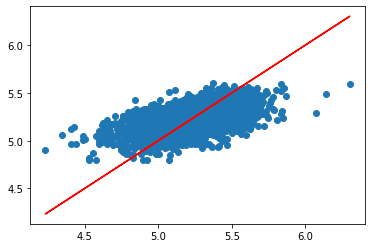

In [170]:
plt.scatter(y_train, y_preds)
plt.plot(y_train, y_train, color="red")

Again extremes are hard to predict but the scatterplot does show a slope.

## Random Forest Regressor

In [171]:
numeric_transformer1 = Pipeline(steps=[
    ('scale',MinMaxScaler()),
    ('impute',KNNImputer())])
numeric_transformer2 = Pipeline(steps=[
    ('log_transform',FunctionTransformer(np.log1p)),
    ('scale',MinMaxScaler()),
    ('impute',KNNImputer())])

cat_transformer = Pipeline(steps=[
    ('scale',MinMaxScaler()),
    ('impute',SimpleImputer(strategy='most_frequent'))
])

preprocessor = ColumnTransformer(transformers=[
    ('num1',numeric_transformer1,numerical_not_skewed),
    ('num2',numeric_transformer2,numerical_variables_skewed),
    ('impute_cat',cat_transformer,categorical_variables+['RIDRETH3'])])

rf1 = Pipeline(steps =[
    ('preprocessor',preprocessor),
    ('rf', RandomForestRegressor(random_state=75))])

In [172]:
rf1.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num1',
                                                  Pipeline(steps=[('scale',
                                                                   MinMaxScaler()),
                                                                  ('impute',
                                                                   KNNImputer())]),
                                                  ['RIDAGEYR', 'Diastolic']),
                                                 ('num2',
                                                  Pipeline(steps=[('log_transform',
                                                                   FunctionTransformer(func=<ufunc 'log1p'>)),
                                                                  ('scale',
                                                                   MinMaxScaler()),
                                                                  ('impute',
                    

In [173]:
r2 = rf1.score(X_train,y_train)
r2

0.8867969156853645

The r2 is large but as seen in the aritcle

# note to self need to reference

r2 is not reliable for non linear models.  Still I am calculating the adjusted r2

In [174]:
k = rf1.named_steps['rf'].n_features_in_
n = X_train.shape[0]
ar2 = 1-(1-r2)*(n-1)/(n-k-1)
ar2

0.8857499140647415

In [175]:
y_preds = rf1.predict(X_train)

In [176]:
training_mae = mean_absolute_error(y_train,y_preds)
training_mae

0.05705232033851686

In [177]:
training_rmse = mean_squared_error(y_train,y_preds,squared=False)
training_rmse

0.07356034529603529

In [178]:
test_mae = np.abs(cross_val_score(estimator=rf1,X=X_train,y=y_train,scoring='neg_mean_absolute_error')).mean()
test_mae

0.15520248138600617

In [179]:
test_rmse = np.sqrt(np.abs(cross_val_score(estimator=rf1,X=X_train,y=y_train,scoring='neg_mean_squared_error')).mean())
test_rmse

0.19782016148986717

As can be seen from the difference in train and test scores, there is some overfitting

In [180]:
metrics['model'].append('rf')
metrics['r2'].append(r2)
metrics['adjusted_r2'].append(ar2)
metrics['train_MAE'].append(training_mae)
metrics['train_RMSE'].append(training_rmse)
metrics['test_MAE'].append(test_mae)
metrics['test_RMSE'].append(test_rmse)

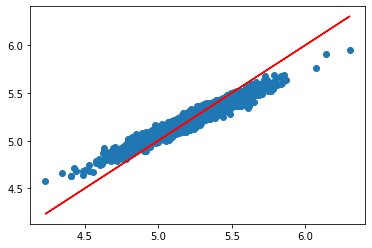

In [181]:
plt.scatter(y_train, y_preds)
plt.plot(y_train, y_train, color="red")

Random forests does the best so far, but still struggles with extreme values.

## Neural Network regression

In [182]:
numeric_transformer1 = Pipeline(steps=[
    ('scale',MinMaxScaler()),
    ('impute',KNNImputer())])
numeric_transformer2 = Pipeline(steps=[
    ('log_transform',FunctionTransformer(np.log1p)),
    ('scale',MinMaxScaler()),
    ('impute',KNNImputer())])

cat_transformer = Pipeline(steps=[
    ('scale',MinMaxScaler()),
    ('impute',SimpleImputer(strategy='most_frequent'))
])

preprocessor = ColumnTransformer(transformers=[
    ('num1',numeric_transformer1,numerical_not_skewed),
    ('num2',numeric_transformer2,numerical_variables_skewed),
    ('impute_cat',cat_transformer,categorical_variables+['RIDRETH3'])])

mlp1 = Pipeline(steps =[
    ('preprocessor',preprocessor),
    ('mlp', KerasRegressor(build_fn=build_model, epochs=25, batch_size=5, verbose=0))])

In [183]:
mlp1.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num1',
                                                  Pipeline(steps=[('scale',
                                                                   MinMaxScaler()),
                                                                  ('impute',
                                                                   KNNImputer())]),
                                                  ['RIDAGEYR', 'Diastolic']),
                                                 ('num2',
                                                  Pipeline(steps=[('log_transform',
                                                                   FunctionTransformer(func=<ufunc 'log1p'>)),
                                                                  ('scale',
                                                                   MinMaxScaler()),
                                                                  ('impute',
                    

In [184]:
y_preds = mlp1.predict(X_train)

In [185]:
training_mae = mean_absolute_error(y_train,y_preds)
training_mae

0.294494426092697

In [186]:
training_rmse = mean_squared_error(y_train,y_preds,squared=False)
training_rmse

0.3514371875792059

For test mean absolute error and root mean square error, instead of using cross validation, I'm using the test set.  Using cross validation will take too much time.

In [190]:
y_test_preds = mlp1.predict(X_test)
test_mae = mean_absolute_error(y_test,y_test_preds)
test_mae

0.28656531735157886

In [192]:
test_rmse =  mean_squared_error(y_test,y_test_preds,squared=False)
test_rmse

0.3459597116735484

In [193]:
metrics['model'].append('nueral_nets')
metrics['r2'].append(None)
metrics['adjusted_r2'].append(None)
metrics['train_MAE'].append(training_mae)
metrics['train_RMSE'].append(training_rmse)
metrics['test_MAE'].append(test_mae)
metrics['test_RMSE'].append(test_rmse)

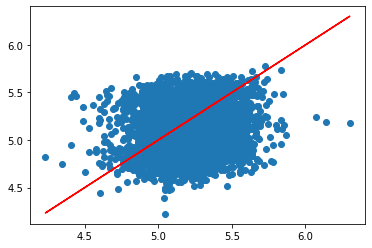

In [189]:
plt.scatter(y_train, y_preds)
plt.plot(y_train, y_train, color="red")

As can be seen the predictions are all over, this does not perform well.  If there were more observations, nueral networks would proably perform better.  Nueral networks like the others fail to predict high level values.

## Comparing models

In [194]:
metrics = pd.DataFrame(metrics)
metrics

,model,r2,adjusted_r2,train_MAE,train_RMSE,test_MAE,test_RMSE
0,ols,0.156214,0.151739,0.156198,0.200831,0.156940,0.201793
1,svr,0.426580,0.423538,0.128231,0.165558,0.163160,0.208801
2,knn,0.326786,0.319606,0.140579,0.179387,0.171554,0.218679
3,rf,0.886797,0.885750,0.057052,0.073560,0.155202,0.197820
4,nueral_nets,NaN,NaN,0.294494,0.351437,0.286565,0.345960


As can be seen random forests performs best with the lowest mean absolute error and root mean square error on both the training and the test set of all models.  So I plan to hyperparameter tune random forests model.

## Hyperparameter tuning

Just copying the pipeline...

In [195]:
numeric_transformer1 = Pipeline(steps=[
    ('scale',MinMaxScaler()),
    ('impute',KNNImputer())])
numeric_transformer2 = Pipeline(steps=[
    ('log_transform',FunctionTransformer(np.log1p)),
    ('scale',MinMaxScaler()),
    ('impute',KNNImputer())])

cat_transformer = Pipeline(steps=[
    ('scale',MinMaxScaler()),
    ('impute',SimpleImputer(strategy='most_frequent'))
])

preprocessor = ColumnTransformer(transformers=[
    ('num1',numeric_transformer1,numerical_not_skewed),
    ('num2',numeric_transformer2,numerical_variables_skewed),
    ('impute_cat',cat_transformer,categorical_variables+['RIDRETH3'])])

rf1 = Pipeline(steps =[
    ('preprocessor',preprocessor),
    ('rf', RandomForestRegressor(random_state=75))])